# Model E + Epochs 75 + Batch Size 4 + With Cross Validation


 Train : 894 Images

 Valid : 75 Images

In [1]:
!nvidia-smi

Thu May 29 11:54:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   31C    P8              6W /  320W |     484MiB /  16376MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

print("number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4080 SUPER


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device : ', device)

using device :  cuda


In [4]:
import os
HOME = os.getcwd()
print(HOME)

c:\5025211148\YOLOv9-Segmentation


In [5]:
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [5]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
Setup complete  (32 CPUs, 63.8 GB RAM, 269.0/476.5 GB disk)


In [6]:
from ultralytics import YOLO
from IPython.display import display, Image

In [8]:
%pip install --user roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
from roboflow import Roboflow
rf = Roboflow(api_key="R66BD6MEFMOCLYffXdn9")
project = rf.workspace("mcab").project("merge-inez")
version = project.version(1)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to merge-inez-1 in yolov9:: 100%|██████████| 1947/1947 [00:00<00:00, 2826.96it/s]


In [7]:
%cd {HOME}


c:\5025211148\YOLOv9-Segmentation


In [11]:
model = YOLO("yolov9e-seg.pt")

In [12]:
model.info()

YOLOv9e-seg summary: 1,261 layers, 60,512,800 parameters, 0 gradients, 248.4 GFLOPs


(1261, 60512800, 0, 248.4070912)

In [13]:
import os
import shutil
from sklearn.model_selection import KFold
from glob import glob
from ultralytics import YOLO

# Path dataset dari Roboflow
base_dataset = r'C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy'
train_images = sorted(glob(os.path.join(base_dataset, 'train', 'images', '*.jpg')))
train_labels = sorted(glob(os.path.join(base_dataset, 'train', 'labels', '*.txt')))

assert len(train_images) == len(train_labels), "Jumlah image dan label tidak cocok."

# Jumlah fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_images)):
    print(f"📁 Menyiapkan Fold {fold + 1}...")

    # Buat folder struktur untuk fold ini
    fold_dir = os.path.join(base_dataset, f'kfold_{fold+1}')
    for subset in ['train', 'val']:
        os.makedirs(os.path.join(fold_dir, 'images', subset), exist_ok=True)
        os.makedirs(os.path.join(fold_dir, 'labels', subset), exist_ok=True)

    # Salin file ke fold train/val
    for idx in train_idx:
        shutil.copy(train_images[idx], os.path.join(fold_dir, 'images', 'train'))
        shutil.copy(train_labels[idx], os.path.join(fold_dir, 'labels', 'train'))

    for idx in val_idx:
        shutil.copy(train_images[idx], os.path.join(fold_dir, 'images', 'val'))
        shutil.copy(train_labels[idx], os.path.join(fold_dir, 'labels', 'val'))

    # Buat file data.yaml untuk fold ini
    yaml_path = os.path.join(fold_dir, 'data.yaml')
    yaml_content = f"""
path: {fold_dir.replace(os.sep, '/')}
train: images/train
val: images/val
nc: 2
names:
  - ab
  - mc
    """.strip()

    with open(yaml_path, 'w') as f:
        f.write(yaml_content)

    # Jalankan training YOLOv9
    print(f"🚀 Training Fold {fold+1}")
    model.train(
        data=yaml_path,
        epochs=75,
        imgsz=640,
        batch=4,
        project="kfold_yolov9_seg",
        name=f"fold{fold+1}",
        exist_ok=True
    )


📁 Menyiapkan Fold 1...
🚀 Training Fold 1
New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: task=segment, mode=train, model=yolov9e-seg.pt, data=C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\kfold_1\data.yaml, epochs=75, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=kfold_yolov9_seg, name=fold1, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_1\labels\train... 715 images, 0 backgrounds, 0 corrupt: 100%|██████████| 715/715 [00:00<00:00, 1610.60it/s]

train: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_1\labels\train.cache



val: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_1\labels\val... 179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 179/179 [00:00<00:00, 973.27it/s]

val: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_1\labels\val.cache


Plotting labels to kfold_yolov9_seg\fold1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 307 weight(decay=0.0), 323 weight(decay=0.0005), 322 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to kfold_yolov9_seg\fold1
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/75      6.95G      1.278      2.281      1.645      1.505         10        640: 100%|██████████| 179/179 [00:33<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.56it/s]

                   all        179        358     0.0535      0.542     0.0433     0.0154     0.0393      0.486     0.0292    0.00797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/75      7.55G      1.295      2.046      1.124      1.525          9        640: 100%|██████████| 179/179 [00:30<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.90it/s]


                   all        179        358       0.28      0.536        0.2     0.0894      0.273      0.464      0.186     0.0756

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/75      7.11G      1.269      1.991      1.023      1.493         10        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]


                   all        179        358      0.822       0.74       0.87       0.49      0.831      0.746      0.879      0.458

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/75      7.16G       1.23       1.87     0.9416       1.47         15        640: 100%|██████████| 179/179 [00:30<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]


                   all        179        358      0.787      0.795      0.884       0.56      0.774      0.786      0.872      0.514

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/75      7.07G       1.14      1.812     0.8866      1.408         12        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179        358      0.825      0.846      0.913      0.583      0.818      0.834      0.894      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/75      7.07G      1.088      1.707     0.7833      1.355         13        640: 100%|██████████| 179/179 [00:29<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.01it/s]

                   all        179        358      0.669      0.822      0.894      0.605       0.67      0.821      0.889      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/75      7.05G       1.09      1.733     0.7429      1.363          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.69it/s]

                   all        179        358      0.924      0.916      0.946      0.637      0.946       0.91      0.952      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/75      7.06G      1.043      1.655     0.7109      1.329         18        640: 100%|██████████| 179/179 [00:35<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        179        358      0.837      0.849      0.927      0.617      0.841      0.851      0.916      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/75      6.44G      1.014      1.625     0.6828      1.315         17        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179        358      0.934      0.933      0.968       0.66      0.945      0.927      0.957      0.633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/75      7.07G     0.9955      1.604     0.6258      1.289         12        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]

                   all        179        358      0.962       0.95       0.98      0.667      0.959      0.947      0.975      0.643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/75      6.44G     0.9862      1.603     0.6282      1.296         11        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.17it/s]


                   all        179        358      0.965       0.95      0.972      0.651      0.969      0.949      0.974       0.62

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/75      7.06G     0.9841      1.562     0.6098      1.286         14        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.97it/s]

                   all        179        358      0.975      0.964      0.982      0.674      0.967      0.955      0.976      0.649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/75      7.07G     0.9529      1.567     0.5857      1.266         10        640: 100%|██████████| 179/179 [00:30<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.04it/s]

                   all        179        358      0.945      0.947      0.965      0.674      0.948       0.95      0.964      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/75      6.43G     0.9538      1.549     0.6023      1.263          7        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]

                   all        179        358      0.965      0.975      0.975      0.669      0.967      0.977      0.975      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/75      7.12G     0.9422      1.503     0.5515      1.257         17        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.09it/s]

                   all        179        358      0.981      0.983      0.988      0.672      0.964      0.966      0.963      0.647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/75      7.09G     0.9376      1.514     0.5607      1.254         18        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]

                   all        179        358      0.943      0.849      0.908      0.645      0.936      0.844      0.899      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/75      7.14G     0.9197      1.507      0.547      1.236          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]

                   all        179        358      0.956      0.967      0.979       0.66      0.959       0.97      0.978      0.637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/75      7.05G     0.9337      1.468     0.5427      1.242         10        640: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]

                   all        179        358      0.957      0.958      0.975      0.689       0.96       0.95       0.97      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/75      7.07G     0.9435       1.51     0.5337      1.262         13        640: 100%|██████████| 179/179 [00:31<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.94it/s]

                   all        179        358      0.961      0.958      0.977      0.691      0.955      0.952      0.967      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/75      7.13G     0.8942      1.469     0.5175      1.231         10        640: 100%|██████████| 179/179 [00:30<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]

                   all        179        358      0.981      0.975      0.986      0.702      0.975      0.969      0.981      0.668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/75      6.44G      0.906      1.495      0.525      1.237         11        640: 100%|██████████| 179/179 [00:30<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]

                   all        179        358      0.968      0.979      0.987      0.686      0.965      0.976      0.987      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/75      7.08G     0.9105      1.455     0.5153      1.231         10        640: 100%|██████████| 179/179 [00:29<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.13it/s]

                   all        179        358      0.981      0.961      0.986       0.69      0.971       0.95      0.973      0.651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/75      7.07G     0.9287      1.488      0.525      1.242         11        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.33it/s]

                   all        179        358      0.977      0.966      0.984      0.698      0.975      0.969      0.984      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/75      7.08G     0.9174      1.449     0.5109      1.225         10        640: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.34it/s]

                   all        179        358       0.97      0.968       0.97      0.697      0.973      0.971      0.975      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/75      7.08G     0.9142      1.497     0.5063      1.226          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]

                   all        179        358      0.967      0.975      0.988        0.7      0.975      0.968      0.983      0.663



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/75       7.1G     0.8729      1.407     0.4879      1.211         19        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.26it/s]

                   all        179        358      0.982      0.966      0.983      0.692      0.981      0.964      0.981      0.675



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/75      7.08G     0.8845      1.425      0.479      1.213         12        640: 100%|██████████| 179/179 [00:30<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]

                   all        179        358      0.978      0.971      0.983      0.711      0.978      0.971      0.986      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/75      6.44G     0.8875      1.447     0.4931      1.213         17        640: 100%|██████████| 179/179 [00:31<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]

                   all        179        358      0.992      0.993      0.995      0.713      0.986      0.977      0.984      0.677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/75      7.07G     0.8445      1.403     0.4636      1.198         14        640: 100%|██████████| 179/179 [00:31<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.63it/s]

                   all        179        358      0.989       0.98      0.991      0.719      0.981      0.971      0.978      0.686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/75      6.44G     0.8673      1.404     0.4639      1.195         12        640: 100%|██████████| 179/179 [00:29<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.17it/s]

                   all        179        358      0.974      0.955      0.979      0.714      0.967      0.961      0.978      0.678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/75      7.14G     0.8715      1.402     0.4746      1.207         14        640: 100%|██████████| 179/179 [00:30<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.36it/s]

                   all        179        358      0.986      0.969      0.989      0.711       0.98      0.964      0.977       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/75       7.1G     0.8708      1.404     0.4628       1.21          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.42it/s]

                   all        179        358      0.971      0.978      0.985      0.706      0.973      0.978      0.983       0.68



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/75      7.08G     0.8641      1.373     0.4597      1.198          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.41it/s]

                   all        179        358       0.99      0.975       0.99      0.722      0.981      0.971      0.985       0.69



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/75      7.07G     0.8628      1.404     0.4564      1.203          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]

                   all        179        358       0.99      0.983      0.992      0.732      0.979      0.972      0.975      0.694



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/75      6.44G     0.8662      1.395      0.451      1.196         11        640: 100%|██████████| 179/179 [00:29<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        179        358      0.989      0.992      0.988      0.733      0.986      0.989      0.985      0.703



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/75      7.05G     0.8443      1.331     0.4332      1.186          9        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.32it/s]

                   all        179        358       0.98      0.992      0.991      0.735      0.992      0.983      0.991      0.706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/75      7.07G      0.835      1.353     0.4338      1.177          9        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.05it/s]

                   all        179        358      0.987      0.963      0.994      0.722      0.983      0.961       0.99      0.693



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/75      6.51G     0.8663       1.39     0.4509      1.192         12        640: 100%|██████████| 179/179 [00:32<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]

                   all        179        358      0.988      0.986      0.993      0.733      0.982       0.98      0.987      0.706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/75      7.07G     0.8233      1.311     0.4203      1.173         12        640: 100%|██████████| 179/179 [00:30<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.66it/s]

                   all        179        358      0.986      0.978      0.987      0.739      0.989      0.978      0.985      0.704



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/75      6.51G     0.8299      1.329     0.4217      1.174          7        640: 100%|██████████| 179/179 [00:30<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.41it/s]

                   all        179        358      0.993       0.98      0.991      0.735       0.99      0.978      0.988      0.711



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/75      6.44G     0.8367      1.341     0.4242      1.179         12        640: 100%|██████████| 179/179 [00:31<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.30it/s]

                   all        179        358      0.998       0.99      0.995       0.72      0.995      0.984       0.99      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/75      7.06G     0.8371      1.351     0.4397       1.19          5        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.38it/s]

                   all        179        358      0.992      0.983      0.989      0.742      0.987      0.976      0.986      0.712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/75      7.04G     0.8236      1.348     0.4152      1.159          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.37it/s]

                   all        179        358      0.992      0.986       0.99      0.745      0.989      0.983      0.986      0.709



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/75      7.07G     0.7918      1.311     0.4036      1.151         11        640: 100%|██████████| 179/179 [00:30<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]

                   all        179        358      0.982      0.986      0.991      0.742      0.985      0.978      0.986      0.709



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/75      7.05G     0.8136        1.3     0.4122      1.171         14        640: 100%|██████████| 179/179 [00:30<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.31it/s]

                   all        179        358      0.995      0.994      0.995      0.751      0.987      0.986      0.989      0.713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/75      7.07G     0.8106      1.312     0.4036      1.157         15        640: 100%|██████████| 179/179 [00:30<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.38it/s]

                   all        179        358      0.995      0.991      0.994      0.737      0.987      0.983      0.988      0.709



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/75      7.09G     0.7965      1.294     0.4063       1.16          5        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]

                   all        179        358      0.987      0.984      0.987       0.75      0.985      0.982      0.985      0.721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/75      7.08G     0.7831      1.254     0.4024      1.149         14        640: 100%|██████████| 179/179 [00:32<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]

                   all        179        358       0.99      0.988      0.991      0.748      0.987      0.985       0.99      0.714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/75      7.16G     0.7857      1.271     0.3902       1.13         17        640: 100%|██████████| 179/179 [00:30<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]

                   all        179        358      0.984      0.989      0.983      0.759      0.987      0.982      0.985      0.721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/75      6.44G     0.8041      1.299     0.3903      1.158         14        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.39it/s]

                   all        179        358      0.985      0.991      0.991       0.74      0.979      0.987       0.99       0.71



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      51/75      7.07G     0.7895      1.264      0.394      1.157          7        640: 100%|██████████| 179/179 [00:30<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.81it/s]

                   all        179        358       0.99      0.986      0.992      0.754       0.99      0.986      0.992      0.724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      52/75      7.04G     0.7822      1.286     0.3883      1.134         16        640: 100%|██████████| 179/179 [00:30<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.16it/s]

                   all        179        358      0.991      0.992      0.994      0.756      0.985      0.986      0.992       0.72



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      53/75      7.07G      0.773      1.256     0.3796      1.126          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.97it/s]

                   all        179        358       0.99      0.991      0.995      0.748      0.987      0.988      0.991      0.716



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      54/75      7.17G     0.7717      1.249     0.3805      1.139         10        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        179        358      0.993      0.988      0.991      0.763      0.987      0.982      0.987       0.72



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      55/75      6.44G     0.7513       1.22     0.3739      1.121         10        640: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.34it/s]

                   all        179        358      0.992      0.992      0.992      0.752      0.992      0.992      0.992      0.724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      56/75      7.06G     0.7536      1.238     0.3723      1.128          9        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]

                   all        179        358      0.992      0.989      0.995      0.761       0.99      0.982      0.991      0.725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      57/75      7.15G     0.7588      1.262     0.3737      1.118         18        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.34it/s]

                   all        179        358      0.995      0.997      0.995      0.751      0.993      0.982      0.989      0.713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      58/75      7.09G     0.7651      1.222     0.3762      1.121         20        640: 100%|██████████| 179/179 [00:31<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.94it/s]

                   all        179        358      0.989      0.989      0.991      0.758      0.987      0.986       0.99      0.722



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      59/75      7.07G     0.7651      1.238     0.3708      1.135         12        640: 100%|██████████| 179/179 [00:31<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.14it/s]

                   all        179        358      0.987      0.992      0.992      0.759      0.984      0.989       0.99      0.727



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      60/75      6.43G     0.7345      1.212     0.3542       1.11         10        640: 100%|██████████| 179/179 [00:31<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]

                   all        179        358      0.992      0.989      0.991      0.768       0.99      0.986      0.989      0.734



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      61/75      7.05G     0.7254      1.187     0.3531      1.095         10        640: 100%|██████████| 179/179 [00:29<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.01it/s]

                   all        179        358      0.991      0.989      0.994       0.77      0.986       0.98      0.991      0.732



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      62/75      6.44G     0.7396      1.204     0.3593      1.115         19        640: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.37it/s]

                   all        179        358      0.993      0.985      0.994      0.767       0.99      0.982      0.992      0.733



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      63/75      6.92G     0.7277      1.191     0.3538      1.116         10        640: 100%|██████████| 179/179 [00:30<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.81it/s]

                   all        179        358      0.993      0.996      0.995      0.764      0.987      0.989      0.988      0.728



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      64/75       7.1G     0.7391      1.199     0.3494      1.102         11        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.26it/s]

                   all        179        358      0.993      0.994      0.995      0.769       0.99      0.991      0.991      0.735



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      65/75      7.07G     0.7154      1.168     0.3418      1.097          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.05it/s]

                   all        179        358      0.988      0.994      0.995      0.774      0.982      0.989      0.991      0.739


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      66/75      7.06G     0.7325      1.237     0.3347       1.12          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.13it/s]

                   all        179        358      0.996      0.994      0.995      0.774      0.996      0.994      0.995      0.734



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      67/75      7.07G     0.7239      1.205     0.3286      1.114          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.36it/s]

                   all        179        358      0.989      0.992      0.991      0.772      0.986      0.989      0.989      0.728



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      68/75      7.03G     0.7098      1.168     0.3272      1.102          6        640: 100%|██████████| 179/179 [00:32<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.10it/s]

                   all        179        358      0.994      0.992      0.995      0.777      0.989      0.986      0.989       0.74



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      69/75      7.06G     0.7034      1.189     0.3207      1.103          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.87it/s]

                   all        179        358      0.991      0.994      0.995      0.778      0.985      0.989       0.99      0.739



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      70/75      7.07G     0.6887      1.161     0.3149      1.095          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]

                   all        179        358      0.996      0.996      0.995      0.778      0.993      0.988       0.99      0.737



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      71/75      7.07G     0.6897      1.174      0.313      1.085          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]

                   all        179        358          1          1      0.995      0.786      0.994      0.992      0.991      0.747



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      72/75      6.41G     0.6795      1.142     0.3067      1.078          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.08it/s]

                   all        179        358      0.999      0.999      0.995      0.788      0.993      0.994      0.991      0.743



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      73/75      7.08G     0.6692      1.152     0.3021      1.078          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.14it/s]

                   all        179        358      0.996      0.994      0.994      0.783       0.99      0.988      0.989      0.742



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      74/75      7.09G     0.6563      1.126     0.3016      1.063          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]


                   all        179        358      0.992      0.997      0.995      0.782      0.986      0.992       0.99      0.739

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      75/75      7.07G      0.662       1.12     0.2962      1.062          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]

                   all        179        358      0.995      0.994      0.995      0.786      0.989      0.989       0.99      0.745



75 epochs completed in 0.737 hours.
Optimizer stripped from kfold_yolov9_seg\fold1\weights\last.pt, 121.9MB
Optimizer stripped from kfold_yolov9_seg\fold1\weights\best.pt, 121.9MB

Validating kfold_yolov9_seg\fold1\weights\best.pt...
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLOv9e-seg summary (fused): 714 layers, 59,683,222 parameters, 0 gradients, 244.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.71it/s]


                   all        179        358          1          1      0.995      0.785      0.994      0.992      0.991      0.747
                    ab        179        179          1          1      0.995      0.972          1          1      0.995      0.926
                    mc        179        179          1          1      0.995      0.599      0.987      0.983      0.987      0.568
Speed: 0.4ms preprocess, 9.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to kfold_yolov9_seg\fold1
📁 Menyiapkan Fold 2...
🚀 Training Fold 2
New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: task=segment, mode=train, model=yolov9e-seg.pt, data=C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\kfold_2\data.yaml, epochs=75, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False

train: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_2\labels\train... 715 images, 0 backgrounds, 0 corrupt: 100%|██████████| 715/715 [00:00<00:00, 1631.84it/s]

train: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_2\labels\train.cache



val: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_2\labels\val... 179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 179/179 [00:00<00:00, 1135.39it/s]


val: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_2\labels\val.cache
Plotting labels to kfold_yolov9_seg\fold2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 307 weight(decay=0.0), 323 weight(decay=0.0005), 322 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to kfold_yolov9_seg\fold2
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/75      8.22G     0.7623      1.251     0.3429      1.148          6        640: 100%|██████████| 179/179 [00:34<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]

                   all        179        358      0.996          1      0.995      0.777      0.993      0.997      0.995      0.752



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/75      7.06G     0.8282      1.321       0.42      1.179          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.52it/s]

                   all        179        358      0.981      0.941      0.971      0.712      0.972      0.933      0.956      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/75      7.07G     0.8592      1.378     0.4398       1.21          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.31it/s]

                   all        179        358      0.915      0.637      0.752      0.568      0.902      0.628      0.739      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/75      7.01G     0.8823      1.427     0.4474      1.217          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]

                   all        179        358      0.936      0.937      0.971      0.689      0.926      0.926      0.961      0.634



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/75      7.01G      0.871      1.401     0.4513      1.224          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.25it/s]

                   all        179        358       0.96      0.975      0.992      0.699      0.953      0.969      0.984      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/75         7G     0.8596      1.386      0.438      1.215          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]

                   all        179        358      0.927       0.96      0.978      0.716      0.925      0.957      0.976      0.694



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/75      7.15G     0.8657      1.385      0.434      1.222          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.13it/s]

                   all        179        358      0.991       0.98      0.994      0.742      0.982      0.972      0.983       0.72



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/75      7.16G      0.869       1.41     0.4399      1.226          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]

                   all        179        358      0.919      0.971      0.984      0.718      0.919      0.961       0.98      0.683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/75      7.14G     0.8693      1.416     0.4396      1.212          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179        358      0.976      0.988      0.993      0.709      0.968      0.979      0.983      0.711



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/75      7.02G     0.8757      1.403     0.4357      1.221          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]

                   all        179        358      0.964      0.977      0.992      0.718       0.95      0.961       0.98      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/75      7.02G     0.8606      1.378     0.4198      1.204          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]

                   all        179        358      0.989      0.989      0.994      0.741      0.986      0.986      0.993      0.721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/75      7.09G     0.8354      1.348     0.4113      1.185          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]

                   all        179        358      0.985      0.994      0.993      0.753      0.984      0.994       0.99      0.734



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/75      7.03G     0.8307      1.341     0.4107      1.187          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.04it/s]

                   all        179        358      0.978      0.986      0.991      0.745      0.975      0.984       0.99       0.73



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/75      7.06G     0.8306      1.337     0.4077      1.183          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179        358      0.991      0.987      0.994      0.752      0.985      0.982      0.987      0.728



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/75      6.86G     0.8167      1.314      0.401      1.163          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]

                   all        179        358      0.989      0.983      0.994      0.759      0.983      0.978      0.989      0.746



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/75      7.07G     0.8025      1.286     0.3998      1.159          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.14it/s]

                   all        179        358      0.962      0.961      0.982      0.729      0.957      0.956      0.977      0.697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/75      7.04G     0.7972        1.3     0.3958      1.157          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.14it/s]

                   all        179        358      0.992      0.983      0.994      0.747      0.983      0.975      0.988      0.718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/75         7G     0.7872      1.269     0.3784      1.151          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

                   all        179        358      0.981      0.986      0.994      0.742      0.975      0.981      0.987      0.714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/75      6.48G     0.8024      1.294     0.3919      1.161          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.06it/s]

                   all        179        358      0.994      0.983      0.994      0.745      0.983      0.976      0.989      0.726



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/75      7.01G     0.8081      1.296     0.4001       1.17          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]

                   all        179        358      0.988      0.985      0.994      0.765      0.982       0.98       0.99      0.736



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/75      6.48G     0.7753      1.265     0.3789      1.139          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]

                   all        179        358      0.984      0.994      0.994      0.764      0.981      0.992       0.99      0.736



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/75       7.1G     0.7678      1.266     0.3763      1.144          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.66it/s]

                   all        179        358      0.985      0.987      0.991      0.744      0.971      0.973      0.978       0.72



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/75         7G     0.7813      1.239     0.3823      1.149          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]

                   all        179        358       0.99      0.994      0.995      0.777      0.979      0.989      0.989      0.753



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/75      7.11G     0.7693      1.234     0.3715      1.139          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.93it/s]

                   all        179        358      0.994      0.992      0.993      0.772      0.985      0.983      0.985      0.754



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/75      7.08G     0.7637       1.24     0.3704      1.129          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.04it/s]


                   all        179        358       0.99      0.983      0.993      0.769      0.978      0.989       0.99       0.74

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/75      7.04G     0.7546      1.237     0.3618       1.13          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]

                   all        179        358      0.989      0.991      0.995      0.767      0.983      0.985      0.991      0.745



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/75      7.14G     0.7465      1.211     0.3466      1.122          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]

                   all        179        358      0.979      0.996      0.994      0.787      0.974      0.991      0.991      0.762



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/75      7.05G      0.753      1.214     0.3564      1.128          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.16it/s]

                   all        179        358      0.995      0.985      0.995      0.797      0.992      0.983      0.992      0.769



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/75      7.09G      0.733      1.203     0.3566      1.119          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.13it/s]

                   all        179        358      0.985      0.994      0.994      0.792      0.982      0.992      0.992      0.766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/75      7.14G     0.7335      1.192     0.3516      1.125          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]


                   all        179        358      0.992       0.99      0.995      0.794      0.983      0.983      0.989      0.765

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/75      7.15G      0.722      1.186     0.3434      1.116          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.52it/s]

                   all        179        358      0.995      0.994      0.995      0.779      0.989      0.989      0.989      0.756



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/75      7.03G     0.7117      1.172     0.3407      1.105          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179        358       0.99      0.989      0.994      0.789       0.99      0.989       0.99       0.76



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/75      7.13G     0.7019      1.133     0.3354      1.098          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        179        358       0.99      0.994      0.995      0.776      0.987      0.991      0.994      0.753



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/75       7.1G     0.7022      1.141     0.3363      1.086          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]

                   all        179        358      0.989      0.972      0.989      0.792      0.989      0.972      0.989      0.766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/75       7.1G     0.7092       1.16     0.3349      1.085          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]

                   all        179        358      0.995      0.989      0.994      0.792      0.989      0.983      0.991      0.774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/75       7.1G      0.704      1.145     0.3275      1.082          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.17it/s]

                   all        179        358      0.986      0.992      0.992        0.8      0.989      0.994      0.992      0.767



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/75      6.44G     0.7055      1.143     0.3322      1.089          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.16it/s]

                   all        179        358      0.978          1      0.994       0.78      0.982      0.985      0.989      0.763



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/75         7G     0.6746      1.094     0.3279      1.066          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]

                   all        179        358      0.999      0.997      0.995      0.783      0.993      0.992      0.989      0.751



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/75      7.02G     0.6764      1.104     0.3243      1.066          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.13it/s]

                   all        179        358      0.993      0.999      0.995      0.796       0.99      0.996      0.993       0.78



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/75      7.02G     0.6843        1.1     0.3282      1.071          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]

                   all        179        358      0.992      0.997      0.995      0.814       0.99      0.994      0.994      0.788



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/75         7G     0.6648      1.081     0.3166      1.073          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]

                   all        179        358      0.998          1      0.995      0.805      0.992      0.994      0.993      0.783



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/75      7.13G     0.6621      1.084     0.3148      1.062          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179        358      0.982      0.997      0.995      0.816      0.982      0.994       0.99      0.785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/75         7G     0.6629      1.087     0.3196      1.062          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.13it/s]

                   all        179        358      0.996      0.999      0.995      0.799      0.991      0.994      0.989      0.777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/75      6.49G     0.6583      1.099     0.3138      1.052          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]

                   all        179        358      0.996      0.998      0.995      0.807      0.993      0.995      0.994      0.784



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/75         7G      0.661      1.092     0.3173      1.054          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        179        358      0.997          1      0.995      0.813      0.997          1      0.995      0.788



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/75      7.19G     0.6265      1.037     0.3015      1.028          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.21it/s]

                   all        179        358      0.994      0.997      0.994      0.809      0.994      0.997      0.995      0.785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/75      7.04G     0.6319      1.074     0.3018      1.052          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.01it/s]

                   all        179        358      0.993      0.985      0.994      0.808       0.99      0.982      0.993      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/75      7.01G     0.6256      1.032      0.297      1.038          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

                   all        179        358      0.999      0.999      0.995      0.816      0.999      0.999      0.995      0.799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/75      7.11G     0.6182       1.03      0.293      1.045          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179        358      0.998      0.997      0.995       0.82      0.998      0.997      0.995      0.792



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/75      7.11G     0.6276      1.059     0.2969      1.037          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]

                   all        179        358      0.998          1      0.995      0.825      0.992      0.994      0.993      0.803



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      51/75      7.12G     0.6053      1.008     0.2901      1.017          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]

                   all        179        358      0.997          1      0.995      0.824      0.988      0.992      0.991      0.799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      52/75      6.45G     0.5972     0.9804     0.2855      1.023          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]

                   all        179        358      0.996      0.999      0.995      0.816      0.996      0.999      0.995      0.798



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      53/75      7.11G     0.5974      1.011     0.2854      1.015          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.56it/s]

                   all        179        358      0.999          1      0.995      0.815      0.993      0.994      0.993      0.782



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      54/75      7.17G     0.6066      1.008     0.2863      1.024          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.35it/s]

                   all        179        358      0.994          1      0.995      0.815      0.986      0.992      0.991      0.789



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      55/75      7.08G     0.5963     0.9691     0.2824      1.024          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.92it/s]

                   all        179        358      0.997      0.992      0.995      0.828      0.987      0.992       0.99      0.797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      56/75      6.45G     0.5873     0.9863     0.2801      1.016          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]

                   all        179        358          1          1      0.995      0.829          1          1      0.995      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      57/75      7.08G     0.5755     0.9713     0.2696      1.009          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.31it/s]

                   all        179        358      0.991      0.997      0.995      0.828      0.991      0.997      0.995      0.803



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      58/75      7.05G     0.5825     0.9707     0.2782      1.007          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]

                   all        179        358      0.995          1      0.995      0.826       0.99      0.994      0.993      0.802



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      59/75         7G     0.5576     0.9399     0.2693      0.985          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]

                   all        179        358      0.992          1      0.995      0.828       0.99      0.994      0.993      0.799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      60/75       7.1G     0.5529     0.9461     0.2686     0.9934          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.41it/s]

                   all        179        358      0.998          1      0.995      0.833      0.992      0.994      0.993       0.81



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      61/75       7.1G     0.5434     0.9343     0.2628     0.9863          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.33it/s]

                   all        179        358      0.997      0.997      0.995      0.838      0.994      0.994      0.995      0.812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      62/75      7.01G     0.5602     0.9429     0.2658     0.9908          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]

                   all        179        358      0.997          1      0.995      0.835      0.997          1      0.995      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      63/75      7.04G     0.5436      0.923     0.2628     0.9781          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.60it/s]


                   all        179        358      0.997          1      0.995      0.834      0.997          1      0.995      0.816

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      64/75      7.07G     0.5294      0.925      0.256     0.9709          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.31it/s]

                   all        179        358      0.998      0.999      0.995      0.835      0.998      0.999      0.995      0.811



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      65/75      7.02G     0.5356     0.9154     0.2599     0.9795          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.05it/s]

                   all        179        358      0.999          1      0.995      0.838      0.999          1      0.995      0.815


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      66/75      7.09G     0.5293     0.8933     0.2583     0.9679          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.27it/s]

                   all        179        358      0.999          1      0.995      0.842      0.999          1      0.995      0.813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      67/75      7.11G     0.5268     0.8965      0.257     0.9787          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.25it/s]

                   all        179        358      0.999          1      0.995      0.836      0.999          1      0.995      0.815



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      68/75      6.45G     0.5155     0.8877      0.255     0.9697          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]

                   all        179        358      0.999          1      0.995      0.833      0.999          1      0.995      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      69/75      7.01G     0.5135     0.8956     0.2514     0.9677          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.08it/s]

                   all        179        358      0.996          1      0.995      0.839      0.996          1      0.995      0.812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      70/75      7.14G     0.5083     0.8705     0.2498     0.9693          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.41it/s]

                   all        179        358      0.996          1      0.995      0.837      0.996          1      0.995      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      71/75         7G     0.5072     0.8664     0.2468     0.9586          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.30it/s]

                   all        179        358      0.999      0.997      0.995      0.844      0.998          1      0.995      0.818



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      72/75      7.01G     0.5035     0.8622     0.2461     0.9492          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]

                   all        179        358      0.998          1      0.995      0.844      0.998          1      0.995      0.816



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      73/75      7.11G     0.4995     0.8662     0.2442     0.9567          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.58it/s]


                   all        179        358      0.999          1      0.995      0.846      0.999          1      0.995       0.82

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      74/75      7.04G     0.4911     0.8483     0.2396     0.9492          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.36it/s]

                   all        179        358      0.998          1      0.995      0.843      0.998          1      0.995      0.819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      75/75      7.04G     0.4946       0.85     0.2393      0.952          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.26it/s]

                   all        179        358      0.998          1      0.995      0.842      0.998          1      0.995      0.816



75 epochs completed in 0.743 hours.
Optimizer stripped from kfold_yolov9_seg\fold2\weights\last.pt, 121.9MB
Optimizer stripped from kfold_yolov9_seg\fold2\weights\best.pt, 121.9MB

Validating kfold_yolov9_seg\fold2\weights\best.pt...
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLOv9e-seg summary (fused): 714 layers, 59,683,222 parameters, 0 gradients, 244.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.66it/s]


                   all        179        358      0.999          1      0.995      0.847      0.999          1      0.995       0.82
                    ab        179        179          1          1      0.995       0.98          1          1      0.995      0.956
                    mc        179        179      0.997          1      0.995      0.714      0.997          1      0.995      0.684
Speed: 0.2ms preprocess, 8.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to kfold_yolov9_seg\fold2
📁 Menyiapkan Fold 3...
🚀 Training Fold 3
New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: task=segment, mode=train, model=yolov9e-seg.pt, data=C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\kfold_3\data.yaml, epochs=75, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False

train: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_3\labels\train... 715 images, 0 backgrounds, 0 corrupt: 100%|██████████| 715/715 [00:00<00:00, 1705.83it/s]

train: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_3\labels\train.cache



val: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_3\labels\val... 179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 179/179 [00:00<00:00, 1097.97it/s]


val: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_3\labels\val.cache
Plotting labels to kfold_yolov9_seg\fold3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 307 weight(decay=0.0), 323 weight(decay=0.0005), 322 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to kfold_yolov9_seg\fold3
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/75      8.39G     0.5897     0.9898     0.2703      1.022          6        640: 100%|██████████| 179/179 [00:32<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.31it/s]

                   all        179        358      0.998          1      0.995      0.873      0.998          1      0.995      0.825



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/75      6.83G     0.6602      1.069     0.3175      1.053          6        640: 100%|██████████| 179/179 [00:32<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.14it/s]

                   all        179        358      0.998          1      0.995      0.853      0.998          1      0.995      0.814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/75      7.12G        0.7      1.126     0.3362      1.101          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.99it/s]

                   all        179        358      0.997      0.994      0.994      0.845      0.997      0.994      0.994      0.809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/75      7.07G     0.7103      1.131     0.3478      1.088          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        179        358      0.983      0.982      0.992      0.814      0.983      0.982      0.992      0.761



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/75      7.02G     0.7095      1.127     0.3535      1.101          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179        358      0.994       0.99      0.994      0.821      0.994       0.99      0.994      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/75      7.02G     0.6936      1.089     0.3391      1.086          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]

                   all        179        358      0.999       0.98      0.994      0.816      0.999       0.98      0.994      0.791



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/75      7.02G     0.7026      1.107     0.3446       1.09          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.97it/s]

                   all        179        358      0.995      0.994      0.995      0.806      0.995      0.994      0.995      0.783



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/75      7.02G     0.7016      1.138     0.3586      1.093          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]

                   all        179        358      0.977       0.98      0.993      0.808      0.974      0.977      0.993      0.777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/75      7.02G     0.6985        1.1      0.342      1.088          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.25it/s]

                   all        179        358      0.989      0.987      0.995      0.827      0.989      0.987      0.995      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/75      7.01G     0.7059       1.14     0.3515      1.094          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]

                   all        179        358      0.986      0.986      0.994      0.825      0.986      0.986      0.994      0.794



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/75      7.01G     0.6988      1.114     0.3466      1.079          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.26it/s]

                   all        179        358      0.985      0.983      0.992      0.828      0.985      0.983      0.992      0.788



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/75         7G     0.6838      1.101     0.3392      1.081          5        640: 100%|██████████| 179/179 [00:30<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]

                   all        179        358      0.982      0.983      0.994      0.792      0.985      0.986      0.995      0.754



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/75      7.01G     0.6839      1.102     0.3354      1.085          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]

                   all        179        358      0.986      0.975      0.994      0.827      0.981      0.983      0.994      0.785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/75      7.01G     0.6913      1.106     0.3339      1.083          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]

                   all        179        358      0.987      0.994      0.994      0.842      0.987      0.994      0.994      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/75      6.83G     0.6809      1.056     0.3321      1.074          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]

                   all        179        358      0.998      0.966      0.992      0.815      0.998      0.966      0.991      0.775



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/75      7.01G     0.6811      1.112     0.3266      1.075          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.19it/s]

                   all        179        358      0.988       0.99      0.993      0.842      0.986      0.997      0.993      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/75       7.1G     0.6653      1.066     0.3289      1.071          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.09it/s]

                   all        179        358      0.993      0.991      0.992      0.833      0.996      0.994      0.994      0.791



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/75      7.02G     0.6696      1.087     0.3211      1.063          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.16it/s]

                   all        179        358      0.973      0.985      0.993      0.816      0.976      0.988      0.994      0.773



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/75      7.02G     0.6615      1.076     0.3175      1.051          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.93it/s]

                   all        179        358      0.995      0.972      0.994      0.802      0.995      0.972      0.994      0.766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/75         7G      0.674      1.094     0.3137       1.07          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.32it/s]

                   all        179        358      0.988      0.994      0.994      0.833      0.988      0.994      0.994      0.797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/75         7G      0.662      1.058     0.3156      1.056          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.16it/s]

                   all        179        358      0.991       0.98      0.991      0.824      0.994      0.983      0.991      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/75      7.01G     0.6433      1.049     0.3106      1.051          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]

                   all        179        358      0.993      0.986      0.994      0.838       0.99      0.983      0.994      0.811



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/75      7.01G     0.6466      1.023     0.3097      1.058          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.05it/s]

                   all        179        358      0.993      0.995      0.995      0.848      0.995      0.992      0.995      0.816



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/75         7G     0.6259       1.01     0.3031      1.034          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.90it/s]

                   all        179        358      0.995      0.992      0.995      0.828      0.995      0.992      0.995       0.79



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/75      7.01G     0.6363      1.032     0.3107      1.042          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.01it/s]

                   all        179        358      0.993      0.988      0.995      0.835      0.996      0.991      0.995        0.8



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/75      7.11G     0.6357      1.015     0.3049      1.035          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]

                   all        179        358      0.996      0.982      0.993      0.784      0.996      0.982      0.993      0.751



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/75      7.06G     0.6317      0.997     0.3042      1.037          5        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179        358      0.999      0.997      0.995      0.856      0.999      0.997      0.995      0.814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/75         7G     0.6217      1.005     0.2986      1.033          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]

                   all        179        358      0.996      0.995      0.995      0.844      0.996      0.995      0.995      0.815



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/75         7G     0.6345     0.9954     0.3038      1.049          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]

                   all        179        358      0.998      0.997      0.995      0.845      0.998      0.997      0.995      0.815



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/75      7.01G     0.6202      1.012     0.2964      1.042          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.33it/s]

                   all        179        358      0.995      0.997      0.995      0.861      0.995      0.997      0.995      0.819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/75       6.8G     0.5984     0.9807     0.2912      1.016          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        179        358      0.993      0.997      0.995      0.839      0.993      0.997      0.995      0.799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/75      7.03G     0.6017     0.9722     0.2867      1.018          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.52it/s]

                   all        179        358      0.996          1      0.995       0.85      0.996          1      0.995      0.812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/75         7G     0.5878      0.978     0.2834      1.016          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]

                   all        179        358      0.994      0.996      0.994      0.833      0.994      0.996      0.994        0.8



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/75         7G     0.5904     0.9584      0.282       1.01          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179        358      0.994      0.992      0.992      0.849      0.994      0.992      0.992       0.82



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/75         7G     0.5869      0.954     0.2849       1.01          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]

                   all        179        358      0.999      0.994      0.995      0.844      0.999      0.994      0.995      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/75         7G     0.5731     0.9261     0.2832     0.9959          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.72it/s]

                   all        179        358      0.989      0.991      0.995      0.832      0.989      0.991      0.995      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/75         7G     0.5918     0.9533     0.2886      1.007          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]

                   all        179        358      0.998      0.997      0.995      0.851      0.998      0.997      0.995      0.823



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/75         7G     0.5862     0.9427     0.2821     0.9942          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.09it/s]

                   all        179        358      0.995      0.989      0.995      0.859      0.995      0.989      0.995       0.82



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/75         7G     0.5647     0.9266     0.2723     0.9945          5        640: 100%|██████████| 179/179 [00:29<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.29it/s]

                   all        179        358      0.999          1      0.995      0.846      0.999          1      0.995      0.811



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/75         7G      0.551     0.9091     0.2698     0.9812          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]

                   all        179        358      0.997      0.997      0.995      0.855      0.997      0.997      0.995      0.823



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/75         7G     0.5704     0.9264     0.2745      1.004          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.32it/s]

                   all        179        358      0.999          1      0.995      0.855      0.999          1      0.995      0.815



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/75      7.03G     0.5721     0.9339      0.274      1.005          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        179        358      0.998      0.997      0.995      0.851      0.998      0.997      0.995      0.813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/75         7G     0.5628     0.9135     0.2708     0.9915          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.53it/s]

                   all        179        358      0.997      0.997      0.995       0.85      0.997      0.997      0.995      0.824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/75      7.15G     0.5441     0.9072     0.2664     0.9767          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179        358          1      0.994      0.995      0.859          1      0.994      0.995      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/75      7.02G      0.545     0.8985     0.2622     0.9799          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.55it/s]

                   all        179        358      0.996          1      0.995      0.856      0.996          1      0.995       0.82



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/75      7.02G     0.5375     0.9043     0.2604     0.9725          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]

                   all        179        358      0.998          1      0.995      0.861      0.998          1      0.995      0.831



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/75      6.83G     0.5419      0.886     0.2637     0.9715          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        179        358      0.995      0.996      0.995      0.862      0.995      0.996      0.995      0.824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/75      7.01G     0.5283     0.8574     0.2592     0.9647          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.16it/s]

                   all        179        358      0.989      0.998      0.995       0.86      0.989      0.998      0.995      0.825



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/75      7.11G     0.5184     0.8721     0.2584     0.9724          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.33it/s]

                   all        179        358      0.999          1      0.995      0.855      0.999          1      0.995      0.826



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/75      7.02G     0.5305     0.8799     0.2579     0.9725          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.09it/s]

                   all        179        358      0.999          1      0.995      0.865      0.996      0.997      0.995      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      51/75      7.02G     0.5089     0.8393     0.2517     0.9537          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.13it/s]

                   all        179        358      0.996          1      0.995      0.856      0.996          1      0.995      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      52/75      7.02G     0.5078     0.8326     0.2504     0.9604          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]

                   all        179        358      0.995          1      0.995      0.869      0.995          1      0.995      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      53/75      7.02G     0.5008     0.8335     0.2491     0.9471          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]

                   all        179        358      0.996      0.999      0.995      0.863      0.996      0.999      0.995      0.828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      54/75         7G     0.5056     0.8447     0.2491     0.9522          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]

                   all        179        358      0.999          1      0.995      0.873      0.999          1      0.995      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      55/75      7.01G     0.4902     0.8353     0.2472     0.9523          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.86it/s]

                   all        179        358      0.996          1      0.995      0.863      0.996          1      0.995      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      56/75      7.15G     0.4915     0.8221     0.2458     0.9485          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.91it/s]

                   all        179        358      0.994          1      0.995      0.863      0.994          1      0.995      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      57/75      7.02G     0.4901       0.83     0.2427     0.9535          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.17it/s]

                   all        179        358      0.996      0.997      0.995       0.87      0.996      0.997      0.995      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      58/75      7.02G     0.4779     0.8182     0.2401      0.947          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]

                   all        179        358      0.999      0.997      0.995       0.87      0.999      0.997      0.995      0.841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      59/75      7.08G     0.4774     0.7966     0.2414     0.9383          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]

                   all        179        358      0.992          1      0.995      0.873      0.992          1      0.995      0.839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      60/75      7.05G     0.4779     0.8058     0.2401     0.9417          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.94it/s]

                   all        179        358      0.999          1      0.995       0.87      0.999          1      0.995      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      61/75      7.02G     0.4639     0.8006     0.2337     0.9392          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]

                   all        179        358      0.996          1      0.995      0.872      0.996          1      0.995      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      62/75      7.02G     0.4727     0.7946      0.233     0.9351          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.17it/s]

                   all        179        358      0.999          1      0.995      0.871      0.999          1      0.995      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      63/75      6.84G     0.4741     0.7928     0.2331     0.9421          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.21it/s]

                   all        179        358      0.997      0.997      0.995      0.872      0.997      0.997      0.995      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      64/75      7.01G     0.4503     0.7678     0.2274     0.9188          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]

                   all        179        358      0.999          1      0.995      0.878      0.999          1      0.995      0.847



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      65/75      7.13G     0.4434     0.7613     0.2295     0.9294          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]

                   all        179        358          1          1      0.995      0.878          1          1      0.995      0.844


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      66/75      7.12G     0.4453      0.754     0.2244     0.9161          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]

                   all        179        358          1          1      0.995      0.881          1          1      0.995      0.845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      67/75      7.12G     0.4411     0.7582     0.2212     0.9269          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]

                   all        179        358          1          1      0.995      0.872          1          1      0.995      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      68/75      7.02G     0.4324     0.7621      0.221     0.9133          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.25it/s]

                   all        179        358      0.999          1      0.995      0.876      0.999          1      0.995      0.844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      69/75      7.02G     0.4454     0.7672     0.2217     0.9265          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.99it/s]

                   all        179        358      0.999          1      0.995      0.875      0.999          1      0.995      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      70/75      7.02G     0.4305     0.7442      0.218      0.916          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.74it/s]

                   all        179        358      0.999          1      0.995      0.876      0.999          1      0.995      0.847



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      71/75      7.02G     0.4237     0.7292     0.2182     0.9175          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.26it/s]

                   all        179        358          1          1      0.995      0.875          1          1      0.995      0.842



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      72/75      7.12G     0.4273     0.7351     0.2141     0.9123          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179        358          1          1      0.995      0.878          1          1      0.995      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      73/75      7.11G     0.4197     0.7381     0.2146     0.9115          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

                   all        179        358      0.999          1      0.995      0.883      0.999          1      0.995      0.845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      74/75      7.03G     0.4211     0.7411     0.2133     0.9076          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.72it/s]

                   all        179        358      0.999          1      0.995      0.878      0.999          1      0.995       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      75/75      7.13G     0.4209      0.732     0.2126      0.911          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]

                   all        179        358      0.999          1      0.995      0.879      0.999          1      0.995       0.85



75 epochs completed in 0.765 hours.
Optimizer stripped from kfold_yolov9_seg\fold3\weights\last.pt, 121.9MB
Optimizer stripped from kfold_yolov9_seg\fold3\weights\best.pt, 121.9MB

Validating kfold_yolov9_seg\fold3\weights\best.pt...
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLOv9e-seg summary (fused): 714 layers, 59,683,222 parameters, 0 gradients, 244.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]


                   all        179        358      0.999          1      0.995      0.879      0.999          1      0.995       0.85
                    ab        179        179      0.998          1      0.995      0.987      0.998          1      0.995      0.966
                    mc        179        179          1          1      0.995      0.771          1          1      0.995      0.733
Speed: 0.3ms preprocess, 8.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to kfold_yolov9_seg\fold3
📁 Menyiapkan Fold 4...
🚀 Training Fold 4
New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: task=segment, mode=train, model=yolov9e-seg.pt, data=C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\kfold_4\data.yaml, epochs=75, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False

train: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_4\labels\train... 715 images, 0 backgrounds, 0 corrupt: 100%|██████████| 715/715 [00:00<00:00, 1642.16it/s]

train: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_4\labels\train.cache



val: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_4\labels\val... 179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 179/179 [00:00<00:00, 1112.13it/s]


val: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_4\labels\val.cache
Plotting labels to kfold_yolov9_seg\fold4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 307 weight(decay=0.0), 323 weight(decay=0.0005), 322 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to kfold_yolov9_seg\fold4
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/75      8.05G     0.4985     0.8547     0.2389     0.9658          6        640: 100%|██████████| 179/179 [00:33<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.32it/s]

                   all        179        358      0.989      0.998      0.995      0.898      0.989      0.998      0.995      0.856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/75      7.04G     0.5685     0.9375     0.2705     0.9996          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.25it/s]

                   all        179        358      0.999          1      0.995      0.883      0.999          1      0.995      0.857



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/75      7.24G     0.5889     0.9602     0.2896       1.02          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.91it/s]

                   all        179        358      0.993          1      0.995      0.877      0.993          1      0.995      0.829



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/75       7.2G     0.6203     0.9899      0.309      1.035          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.87it/s]

                   all        179        358      0.996          1      0.995      0.875      0.996          1      0.995      0.852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/75       7.2G     0.6071     0.9868     0.3069      1.025          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.49it/s]

                   all        179        358      0.993      0.997      0.995      0.879      0.993      0.997      0.995       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/75      7.18G     0.6144     0.9986     0.3049      1.032          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.92it/s]

                   all        179        358      0.991      0.997      0.994      0.857      0.988      0.994      0.994      0.813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/75      7.18G     0.6123     0.9803     0.3034      1.028          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179        358       0.99      0.984      0.988      0.804      0.984      0.978      0.985      0.766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/75      7.18G     0.6292      1.014     0.3049       1.05          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179        358      0.997      0.997      0.995      0.866      0.997      0.997      0.995      0.842



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/75      7.18G     0.6071     0.9582      0.302      1.021          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.67it/s]

                   all        179        358      0.999      0.997      0.995       0.87      0.999      0.997      0.995      0.838



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/75      7.03G     0.6053      0.969     0.3066      1.025          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]

                   all        179        358      0.996          1      0.995      0.864      0.993      0.997      0.995       0.82



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/75      7.28G     0.6018     0.9586     0.2962      1.019          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]

                   all        179        358      0.997          1      0.995      0.846      0.997          1      0.995      0.802



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/75      7.21G      0.603     0.9657     0.2982      1.026          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        179        358      0.995          1      0.995      0.854      0.995          1      0.995       0.83



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/75      7.21G     0.5904     0.9525     0.2877       1.02          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.29it/s]

                   all        179        358      0.996          1      0.995      0.859      0.996          1      0.995      0.824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/75      7.21G     0.5968     0.9509     0.2912      1.014          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]

                   all        179        358      0.996          1      0.995      0.866      0.996          1      0.995      0.839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/75      6.81G     0.5892     0.9501     0.2926      1.003          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.29it/s]

                   all        179        358      0.996      0.997      0.995      0.861      0.993      0.994      0.995       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/75      7.21G     0.5883     0.9533     0.2902      1.004          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        179        358      0.993      0.997      0.995      0.868      0.993      0.997      0.995      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/75      7.21G     0.5845     0.9452     0.2861       1.01          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.69it/s]

                   all        179        358      0.992          1      0.993      0.865      0.992          1      0.993      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/75      7.19G     0.5818      0.961     0.2919      1.009          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        179        358      0.993      0.997      0.995      0.864      0.993      0.997      0.995      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/75      7.19G     0.5747     0.9258     0.2811          1          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.04it/s]

                   all        179        358      0.989      0.997      0.995      0.855      0.989      0.997      0.995      0.826



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/75      7.19G     0.5737     0.9189     0.2805     0.9998          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        179        358      0.999          1      0.995      0.872      0.999          1      0.995       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/75      7.19G     0.5701      0.923     0.2869     0.9988          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]

                   all        179        358      0.998          1      0.995      0.863      0.995      0.997      0.995      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/75      7.19G     0.5695     0.9287     0.2867     0.9967          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        179        358       0.99      0.989      0.994       0.85      0.987      0.986      0.992      0.814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/75      7.19G     0.5596     0.9105     0.2804     0.9992          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.30it/s]

                   all        179        358      0.998          1      0.995      0.865      0.998          1      0.995       0.83



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/75      7.19G     0.5588     0.9223     0.2745     0.9919          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]

                   all        179        358      0.993          1      0.995      0.862      0.993          1      0.995      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/75      7.18G      0.552     0.9116     0.2718     0.9943          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]

                   all        179        358      0.997          1      0.995      0.855      0.997          1      0.995      0.828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/75      7.18G     0.5592     0.9038     0.2728     0.9901          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]

                   all        179        358      0.996      0.999      0.995      0.867      0.996      0.999      0.995      0.844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/75      7.18G     0.5456      0.891     0.2693     0.9796          6        640: 100%|██████████| 179/179 [00:32<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]

                   all        179        358      0.994      0.987      0.994      0.862      0.992      0.984      0.993      0.831



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/75      7.18G      0.544     0.8973     0.2677     0.9921          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        179        358      0.996          1      0.995      0.867      0.996          1      0.995      0.849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/75      7.18G     0.5548     0.8806     0.2687     0.9916          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]


                   all        179        358       0.99      0.995      0.995       0.86       0.99      0.995      0.995      0.838

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/75      7.18G     0.5354     0.8839     0.2643     0.9807          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.36it/s]

                   all        179        358      0.996          1      0.995      0.875      0.993      0.997      0.995      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/75      6.82G     0.5406     0.8576     0.2636     0.9767          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]

                   all        179        358      0.996          1      0.995      0.879      0.996          1      0.995      0.854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/75      7.24G     0.5198     0.8525     0.2639     0.9711          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.27it/s]

                   all        179        358      0.995      0.998      0.995      0.874      0.995      0.998      0.995      0.857



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/75      7.21G      0.519     0.8552     0.2621     0.9689          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.13it/s]

                   all        179        358      0.996          1      0.995      0.879      0.993      0.997      0.995      0.854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/75      7.19G     0.5128       0.83     0.2573     0.9542          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.66it/s]

                   all        179        358      0.995      0.994      0.995      0.863      0.995      0.994      0.995      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/75      7.19G     0.5136     0.8538      0.256     0.9591          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.19it/s]

                   all        179        358      0.999      0.996      0.995      0.868      0.999      0.996      0.995      0.839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/75      7.19G     0.5057     0.8283     0.2536      0.953          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.57it/s]

                   all        179        358      0.992      0.997      0.995      0.875      0.992      0.997      0.995      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/75      7.18G     0.5175      0.838     0.2543      0.961          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        179        358      0.996          1      0.995      0.882      0.993      0.997      0.995      0.856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/75      7.18G     0.5026      0.808     0.2523       0.95          5        640: 100%|██████████| 179/179 [00:30<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]

                   all        179        358      0.996          1      0.995      0.884      0.996          1      0.995      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/75      7.18G     0.4968     0.8002     0.2496      0.953          5        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.30it/s]

                   all        179        358      0.995          1      0.995      0.877      0.995          1      0.995       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/75      7.18G     0.4861      0.814     0.2492     0.9464          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.30it/s]

                   all        179        358      0.999          1      0.995       0.88      0.999          1      0.995       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/75      7.18G     0.4783     0.8069     0.2458     0.9446          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.62it/s]

                   all        179        358      0.998          1      0.995      0.893      0.998          1      0.995      0.862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/75      7.18G     0.4769     0.8001     0.2433     0.9408          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]

                   all        179        358      0.996          1      0.995      0.879      0.996          1      0.995       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/75      7.18G     0.4768     0.7921     0.2428      0.938          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179        358      0.999          1      0.995      0.873      0.999          1      0.995      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/75      7.18G     0.4771     0.7883     0.2395     0.9423          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]

                   all        179        358      0.999          1      0.995      0.881      0.999          1      0.995      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/75      7.18G     0.4685      0.789     0.2384     0.9463          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]

                   all        179        358      0.999          1      0.995      0.889      0.996      0.997      0.995      0.853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/75      7.18G     0.4676     0.7762     0.2371      0.932          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]

                   all        179        358      0.996          1      0.995      0.887      0.996          1      0.995      0.856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/75      6.82G     0.4629     0.7926     0.2341     0.9428          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        179        358      0.999          1      0.995      0.893      0.999          1      0.995       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/75      7.22G     0.4549     0.7627     0.2305     0.9235          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]

                   all        179        358      0.998          1      0.995      0.878      0.998          1      0.995      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/75      7.18G     0.4639     0.7768     0.2323     0.9328          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.16it/s]

                   all        179        358      0.999          1      0.995      0.889      0.999          1      0.995      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/75      7.18G     0.4603      0.776     0.2336     0.9367          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        179        358      0.999          1      0.995      0.878      0.999          1      0.995      0.848



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      51/75      7.18G     0.4552     0.7566     0.2312     0.9197          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.21it/s]

                   all        179        358          1          1      0.995      0.886          1          1      0.995      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      52/75      7.18G     0.4464      0.732     0.2283      0.921          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.69it/s]

                   all        179        358      0.998          1      0.995      0.885      0.995      0.997      0.995      0.846



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      53/75      7.18G     0.4449     0.7495      0.226     0.9244          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.94it/s]

                   all        179        358      0.999          1      0.995      0.887      0.996      0.997      0.995      0.853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      54/75      7.18G     0.4421     0.7508     0.2256     0.9187          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        179        358      0.999          1      0.995      0.886      0.999          1      0.995      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      55/75      7.18G      0.433     0.7432     0.2231     0.9214          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.71it/s]

                   all        179        358      0.999          1      0.995      0.887      0.999          1      0.995      0.853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      56/75      7.18G     0.4276     0.7352     0.2229      0.916          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


                   all        179        358      0.999      0.999      0.995      0.884      0.999      0.999      0.995      0.851

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      57/75      7.18G     0.4227     0.7124     0.2156     0.9052          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.71it/s]

                   all        179        358      0.999          1      0.995      0.884      0.999          1      0.995      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      58/75      7.04G     0.4265     0.7242     0.2186     0.9111          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.94it/s]

                   all        179        358      0.999          1      0.995       0.89      0.999          1      0.995      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      59/75      7.28G     0.4185     0.7091     0.2144     0.9066          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.06it/s]

                   all        179        358      0.999          1      0.995       0.89      0.999          1      0.995      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      60/75      7.28G     0.4206     0.7142     0.2151     0.9071          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]

                   all        179        358      0.996          1      0.995      0.886      0.996          1      0.995      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      61/75      7.21G     0.4155     0.7157     0.2148     0.9133          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]

                   all        179        358      0.998          1      0.995      0.878      0.998          1      0.995      0.853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      62/75      7.21G     0.4034     0.6959     0.2089     0.9011          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.75it/s]

                   all        179        358      0.998          1      0.995       0.89      0.998          1      0.995      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      63/75      6.81G      0.401     0.6984      0.211     0.8994          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.06it/s]

                   all        179        358      0.997          1      0.995      0.885      0.997          1      0.995      0.856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      64/75      7.22G      0.397     0.6784      0.205     0.8906          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.09it/s]

                   all        179        358      0.998          1      0.995      0.892      0.998          1      0.995      0.862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      65/75      7.19G     0.3989     0.6948     0.2093     0.8948          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]

                   all        179        358      0.999          1      0.995       0.89      0.999          1      0.995      0.861


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      66/75      7.19G     0.3817     0.6665     0.2028     0.8852          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.56it/s]

                   all        179        358          1          1      0.995      0.888          1          1      0.995      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      67/75      7.19G     0.3903     0.6844     0.2033     0.8936          6        640: 100%|██████████| 179/179 [00:31<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.81it/s]

                   all        179        358      0.999          1      0.995      0.888      0.999          1      0.995      0.861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      68/75      7.19G     0.3837     0.6776     0.2036     0.8928          6        640: 100%|██████████| 179/179 [00:29<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.19it/s]

                   all        179        358          1          1      0.995      0.894          1          1      0.995      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      69/75      7.19G      0.381     0.6797     0.1992     0.8934          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.13it/s]

                   all        179        358      0.999          1      0.995      0.895      0.996      0.997      0.995      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      70/75      7.19G     0.3799     0.6668     0.2003     0.8853          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.08it/s]

                   all        179        358          1          1      0.995      0.894      0.997      0.997      0.995       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      71/75      7.19G     0.3763     0.6498     0.1991     0.8838          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]

                   all        179        358          1          1      0.995      0.894      0.997      0.997      0.995       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      72/75      7.19G     0.3679     0.6484     0.1956     0.8764          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.76it/s]

                   all        179        358          1          1      0.995      0.892          1          1      0.995      0.856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      73/75      7.19G     0.3743     0.6496     0.1993     0.8889          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.14it/s]

                   all        179        358      0.999          1      0.995      0.896      0.999          1      0.995      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      74/75      7.03G     0.3656     0.6427     0.1958     0.8788          6        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]

                   all        179        358      0.999          1      0.995      0.895      0.999          1      0.995      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      75/75      7.32G     0.3704     0.6571      0.196     0.8793          6        640: 100%|██████████| 179/179 [00:30<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.67it/s]

                   all        179        358      0.999          1      0.995      0.896      0.999          1      0.995      0.862



75 epochs completed in 0.765 hours.
Optimizer stripped from kfold_yolov9_seg\fold4\weights\last.pt, 121.9MB
Optimizer stripped from kfold_yolov9_seg\fold4\weights\best.pt, 121.9MB

Validating kfold_yolov9_seg\fold4\weights\best.pt...
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLOv9e-seg summary (fused): 714 layers, 59,683,222 parameters, 0 gradients, 244.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.49it/s]


                   all        179        358      0.999          1      0.995      0.896      0.999          1      0.995      0.864
                    ab        179        179      0.999          1      0.995      0.989      0.999          1      0.995      0.973
                    mc        179        179          1          1      0.995      0.803          1          1      0.995      0.755
Speed: 0.3ms preprocess, 8.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to kfold_yolov9_seg\fold4
📁 Menyiapkan Fold 5...
🚀 Training Fold 5
New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: task=segment, mode=train, model=yolov9e-seg.pt, data=C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\kfold_5\data.yaml, epochs=75, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False

train: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_5\labels\train... 716 images, 0 backgrounds, 0 corrupt: 100%|██████████| 716/716 [00:00<00:00, 1593.88it/s]


train: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_5\labels\train.cache


val: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_5\labels\val... 178 images, 0 backgrounds, 0 corrupt: 100%|██████████| 178/178 [00:00<00:00, 1220.42it/s]

val: New cache created: C:\5025211148\YOLOv9-Segmentation\merge-inez-1 copy\kfold_5\labels\val.cache


Plotting labels to kfold_yolov9_seg\fold5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 307 weight(decay=0.0), 323 weight(decay=0.0005), 322 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to kfold_yolov9_seg\fold5
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/75       8.2G     0.4417     0.7685     0.2162     0.9266          8        640: 100%|██████████| 179/179 [00:35<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.09it/s]

                   all        178        356          1          1      0.995       0.91          1          1      0.995      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/75      7.73G     0.4971     0.8357     0.2425     0.9468          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]

                   all        178        356      0.999          1      0.995      0.924      0.999          1      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/75      7.69G      0.547     0.8809     0.2638     0.9931          8        640: 100%|██████████| 179/179 [00:29<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        178        356      0.999          1      0.995        0.9      0.999          1      0.995      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/75      7.69G     0.5514     0.9052     0.2754     0.9904          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.30it/s]

                   all        178        356      0.996      0.995      0.995      0.886      0.996      0.995      0.995      0.844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/75      7.69G     0.5611     0.9097     0.2806     0.9918          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.49it/s]

                   all        178        356      0.988      0.989      0.995       0.89      0.988      0.989      0.995      0.867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/75      7.69G     0.5893     0.9354     0.2916      1.007          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.06it/s]

                   all        178        356      0.996          1      0.995      0.892      0.996          1      0.995      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/75      7.69G     0.5683     0.9118     0.2809     0.9851          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.19it/s]

                   all        178        356      0.998          1      0.995      0.891      0.998          1      0.995      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/75      7.69G     0.5443     0.8923     0.2705     0.9835          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.27it/s]

                   all        178        356      0.991      0.997      0.995      0.896      0.991      0.997      0.995       0.87



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/75      7.69G     0.5383     0.8651     0.2709      0.978          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.25it/s]

                   all        178        356      0.998          1      0.995      0.896      0.998          1      0.995      0.866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/75      7.69G      0.539     0.8802      0.268     0.9806          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.26it/s]

                   all        178        356      0.996          1      0.995      0.899      0.996          1      0.995       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/75      7.69G     0.5446     0.8789     0.2744      0.974          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]

                   all        178        356      0.994      0.997      0.994      0.866      0.994      0.997      0.994      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/75      7.69G     0.5418     0.8889     0.2771     0.9798          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]

                   all        178        356      0.998          1      0.995      0.878      0.998          1      0.995      0.848



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/75      7.69G     0.5375     0.8886     0.2677     0.9873          8        640: 100%|██████████| 179/179 [00:29<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.32it/s]

                   all        178        356      0.999          1      0.995       0.89      0.999          1      0.995      0.852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/75      7.69G     0.5407     0.8555     0.2689     0.9769          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.17it/s]

                   all        178        356      0.999          1      0.995      0.891      0.999          1      0.995      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/75      7.69G      0.554     0.8704     0.2785     0.9785          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        178        356      0.994      0.991      0.995      0.876      0.994      0.991      0.995      0.848



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/75      7.69G     0.5555     0.8835     0.2725     0.9849          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

                   all        178        356      0.999          1      0.995      0.883      0.999          1      0.995      0.852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/75      7.69G      0.551     0.8761     0.2692     0.9784          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.86it/s]

                   all        178        356      0.976       0.92      0.969      0.829      0.976       0.92      0.969      0.784



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/75      7.69G     0.5424     0.8995     0.2673     0.9739          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.67it/s]

                   all        178        356      0.989      0.977      0.993      0.862      0.989      0.977      0.993      0.829



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/75      7.69G     0.5217     0.8429     0.2632     0.9559          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]

                   all        178        356          1          1      0.995      0.904          1          1      0.995      0.872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/75      7.69G      0.515     0.8628      0.254     0.9596          8        640: 100%|██████████| 179/179 [00:29<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.34it/s]

                   all        178        356      0.999          1      0.995      0.887      0.999          1      0.995      0.861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/75      7.69G     0.5151     0.8354     0.2603     0.9552          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.34it/s]

                   all        178        356      0.998      0.997      0.995      0.888      0.998      0.997      0.995      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/75      7.69G     0.5166     0.8402     0.2579     0.9616          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.72it/s]

                   all        178        356      0.997          1      0.995      0.891      0.997          1      0.995      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/75      7.69G     0.5251     0.8249     0.2602     0.9662          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.25it/s]

                   all        178        356      0.998          1      0.995      0.894      0.998          1      0.995      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/75      7.69G     0.5099      0.845     0.2548     0.9507          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]

                   all        178        356      0.993          1      0.995      0.876      0.993          1      0.995      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/75      7.69G     0.5166     0.8429     0.2594     0.9622          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]

                   all        178        356      0.999          1      0.995      0.884      0.999          1      0.995      0.852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/75      7.69G     0.4939      0.815     0.2528      0.939          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]

                   all        178        356      0.999          1      0.995      0.901      0.999          1      0.995      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/75      7.69G     0.4896     0.7879     0.2474     0.9482          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.21it/s]

                   all        178        356      0.997          1      0.995      0.895      0.997          1      0.995      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/75      7.69G     0.4849     0.7839     0.2467     0.9431          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]

                   all        178        356      0.996          1      0.995      0.896      0.996          1      0.995      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/75      7.69G     0.4918     0.8176     0.2498     0.9534          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.10it/s]

                   all        178        356      0.995          1      0.995      0.894      0.995          1      0.995      0.867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/75      7.69G     0.4822     0.8016      0.248     0.9405          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.26it/s]

                   all        178        356      0.999          1      0.995      0.897      0.999          1      0.995      0.866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/75      7.69G     0.4813     0.7879     0.2466     0.9357          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.32it/s]

                   all        178        356      0.999          1      0.995        0.9      0.999          1      0.995      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/75      7.67G     0.4738     0.7704     0.2423     0.9364          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.34it/s]

                   all        178        356      0.999          1      0.995      0.893      0.999          1      0.995      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/75      7.67G     0.4718     0.7613     0.2416     0.9288          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]

                   all        178        356      0.999          1      0.995      0.896      0.999          1      0.995      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/75      7.67G     0.4668     0.7729     0.2386     0.9307          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.37it/s]

                   all        178        356      0.999          1      0.995        0.9      0.999          1      0.995      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/75      7.67G     0.4535     0.7612     0.2325     0.9188          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]

                   all        178        356          1          1      0.995      0.904          1          1      0.995      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/75      7.67G     0.4607     0.7532     0.2368     0.9223          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.63it/s]

                   all        178        356      0.997          1      0.995      0.903      0.997          1      0.995      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/75      7.67G     0.4558     0.7339      0.238     0.9145          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.87it/s]

                   all        178        356          1          1      0.995      0.898          1          1      0.995      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/75      7.67G     0.4489     0.7367     0.2297     0.9168          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.92it/s]

                   all        178        356      0.999          1      0.995        0.9      0.999          1      0.995      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/75      7.67G     0.4503     0.7447     0.2326     0.9258          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        178        356      0.999          1      0.995      0.898      0.999          1      0.995      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/75      7.67G     0.4435     0.7193     0.2341     0.9157          7        640: 100%|██████████| 179/179 [00:30<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]

                   all        178        356      0.996          1      0.995      0.897      0.996          1      0.995      0.866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/75      7.67G     0.4435     0.7458     0.2294     0.9265          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        178        356      0.999          1      0.995      0.896      0.999          1      0.995       0.87



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/75      7.67G     0.4375     0.7395     0.2266     0.9225          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.29it/s]

                   all        178        356          1          1      0.995      0.904          1          1      0.995      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/75      7.67G      0.435     0.7191     0.2249     0.9145          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]

                   all        178        356      0.997          1      0.995      0.899      0.997          1      0.995      0.874



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/75      7.67G     0.4381     0.7152     0.2244      0.917          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.34it/s]

                   all        178        356      0.999          1      0.995      0.906      0.999          1      0.995      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/75      7.67G     0.4213      0.706     0.2231     0.9076          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.08it/s]

                   all        178        356          1          1      0.995      0.907          1          1      0.995      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/75      7.67G     0.4087     0.7037     0.2194     0.8987          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.21it/s]

                   all        178        356      0.999          1      0.995      0.906      0.999          1      0.995      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/75      7.67G     0.4202     0.7004     0.2175     0.9092          7        640: 100%|██████████| 179/179 [00:31<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]

                   all        178        356      0.999          1      0.995      0.903      0.999          1      0.995      0.874



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/75      7.67G     0.4142      0.697     0.2163        0.9          7        640: 100%|██████████| 179/179 [00:30<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]

                   all        178        356      0.999          1      0.995      0.909      0.999          1      0.995       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/75      7.67G     0.4121     0.6952     0.2166      0.901          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.52it/s]

                   all        178        356          1          1      0.995      0.908          1          1      0.995      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/75      7.67G     0.4067      0.683     0.2125     0.9039          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.76it/s]

                   all        178        356      0.999          1      0.995      0.907      0.999          1      0.995      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      51/75      7.67G     0.4121     0.6726     0.2138     0.9003          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]

                   all        178        356      0.999          1      0.995      0.897      0.999          1      0.995      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      52/75      7.67G     0.4089     0.6673     0.2128     0.9049          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.36it/s]

                   all        178        356      0.999          1      0.995      0.912      0.999          1      0.995      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      53/75      7.67G     0.3959     0.6605     0.2104     0.8905          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.01it/s]

                   all        178        356          1          1      0.995      0.914          1          1      0.995      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      54/75      7.67G        0.4     0.6674     0.2116     0.8939          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.30it/s]

                   all        178        356          1          1      0.995      0.902          1          1      0.995      0.874



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      55/75      7.67G     0.4005     0.6923     0.2088     0.8995          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.32it/s]

                   all        178        356      0.997          1      0.995      0.911      0.997          1      0.995       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      56/75      7.67G     0.3966     0.6797     0.2082     0.8956          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.66it/s]

                   all        178        356      0.999          1      0.995      0.904      0.999          1      0.995      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      57/75      7.67G     0.3834     0.6553      0.204     0.8944          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.50it/s]

                   all        178        356          1          1      0.995      0.909          1          1      0.995      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      58/75      7.67G     0.3788     0.6667     0.2009     0.8713          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.81it/s]

                   all        178        356          1          1      0.995      0.902          1          1      0.995      0.878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      59/75      7.67G     0.3686     0.6344     0.1983     0.8813          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.31it/s]

                   all        178        356      0.997          1      0.995      0.912      0.997          1      0.995      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      60/75      7.67G      0.378     0.6527     0.2016      0.884          7        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]

                   all        178        356      0.997          1      0.995      0.903      0.997          1      0.995      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      61/75      7.67G     0.3663     0.6426     0.1985     0.8792          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]

                   all        178        356          1          1      0.995      0.905          1          1      0.995       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      62/75      7.67G     0.3661      0.635        0.2     0.8775          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.35it/s]

                   all        178        356      0.999          1      0.995      0.907      0.999          1      0.995      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      63/75      7.67G     0.3614     0.6232     0.1942     0.8753          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.21it/s]

                   all        178        356      0.997          1      0.995      0.904      0.997          1      0.995      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      64/75      7.67G     0.3569     0.6118     0.1912      0.871          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]

                   all        178        356      0.997          1      0.995      0.912      0.997          1      0.995      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      65/75      7.67G      0.355     0.6223     0.1923     0.8688          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.29it/s]

                   all        178        356      0.997          1      0.995      0.911      0.997          1      0.995       0.88


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      66/75      7.67G     0.3468     0.6051      0.191      0.863          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.33it/s]

                   all        178        356          1          1      0.995       0.91          1          1      0.995      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      67/75      7.67G     0.3499     0.6083     0.1918     0.8637          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.94it/s]

                   all        178        356          1          1      0.995      0.906          1          1      0.995      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      68/75      7.67G     0.3495     0.6015     0.1894     0.8622          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

                   all        178        356          1          1      0.995      0.911          1          1      0.995      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      69/75      7.67G     0.3458     0.6015     0.1888     0.8636          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]

                   all        178        356          1          1      0.995      0.908          1          1      0.995      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      70/75      7.67G     0.3385     0.5912     0.1859     0.8642          8        640: 100%|██████████| 179/179 [00:31<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.61it/s]

                   all        178        356          1          1      0.995      0.908          1          1      0.995      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      71/75      7.67G     0.3333     0.5837     0.1844     0.8581          7        640: 100%|██████████| 179/179 [00:30<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.30it/s]

                   all        178        356          1          1      0.995       0.91          1          1      0.995      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      72/75      7.67G     0.3317     0.5867     0.1842     0.8659          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.29it/s]

                   all        178        356          1          1      0.995       0.91          1          1      0.995      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      73/75      7.67G     0.3259     0.5809     0.1819       0.86          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.29it/s]

                   all        178        356          1          1      0.995      0.911          1          1      0.995      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      74/75      7.67G     0.3332     0.5785     0.1836     0.8617          8        640: 100%|██████████| 179/179 [00:30<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]

                   all        178        356          1          1      0.995      0.913          1          1      0.995      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      75/75      7.67G     0.3237     0.5793     0.1783     0.8583          8        640: 100%|██████████| 179/179 [00:29<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.32it/s]

                   all        178        356          1          1      0.995      0.911          1          1      0.995      0.886



75 epochs completed in 0.763 hours.
Optimizer stripped from kfold_yolov9_seg\fold5\weights\last.pt, 121.9MB
Optimizer stripped from kfold_yolov9_seg\fold5\weights\best.pt, 121.9MB

Validating kfold_yolov9_seg\fold5\weights\best.pt...
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLOv9e-seg summary (fused): 714 layers, 59,683,222 parameters, 0 gradients, 244.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.10it/s]


                   all        178        356      0.999          1      0.995      0.924      0.999          1      0.995      0.895
                    ab        178        178      0.998          1      0.995      0.986      0.998          1      0.995      0.976
                    mc        178        178          1          1      0.995      0.862          1          1      0.995      0.813
Speed: 0.2ms preprocess, 8.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to kfold_yolov9_seg\fold5


In [10]:
result = model.train(data="C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1\\data.yaml", epochs=75, imgsz=640, batch=4)

New https://pypi.org/project/ultralytics/8.3.95 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: task=segment, mode=train, model=yolov9e-seg.pt, data=C:\5025211148\YOLOv9-Segmentation\merge-inez-1\data.yaml, epochs=75, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, ret

train: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1\train\labels.cache... 894 images, 0 backgrounds, 0 corrupt: 100%|██████████| 894/894 [00:00<?, ?it/s]
val: Scanning C:\5025211148\YOLOv9-Segmentation\merge-inez-1\valid\labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]

val: WARNING  C:\5025211148\YOLOv9-Segmentation\merge-inez-1\valid\images\slice_234_jpg.rf.8c97c306d89d4aea1956db536d9ae8da.jpg: 1 duplicate labels removed


Plotting labels to runs\segment\train22\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 307 weight(decay=0.0), 323 weight(decay=0.0005), 322 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\segment\train22
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/75      7.01G       1.25      2.183      1.461      1.535          4        640: 100%|██████████| 224/224 [00:42<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]

                   all         75        150    0.00263       0.08    0.00201   0.000432   0.000129    0.00667   5.42e-05    1.2e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/75      7.15G      1.248      1.981      1.036       1.53          4        640: 100%|██████████| 224/224 [00:37<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.26it/s]

                   all         75        150      0.961      0.493      0.613      0.448      0.961      0.493      0.616      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/75      7.16G      1.187      1.864     0.9258      1.492          9        640: 100%|██████████| 224/224 [00:37<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.36it/s]

                   all         75        150      0.528      0.747       0.59      0.375       0.53      0.752      0.584      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/75      7.16G      1.136      1.873     0.8518      1.462          7        640: 100%|██████████| 224/224 [00:38<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


                   all         75        150      0.724       0.76      0.708      0.489      0.683       0.74      0.666      0.426

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/75      7.15G      1.077      1.745     0.7583      1.406          5        640: 100%|██████████| 224/224 [00:38<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.08it/s]

                   all         75        150      0.788       0.74      0.697      0.524       0.77      0.749      0.694      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/75      7.15G      1.076      1.696     0.7145      1.389          8        640: 100%|██████████| 224/224 [00:37<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.43it/s]

                   all         75        150        0.7      0.723      0.692      0.502      0.697      0.727      0.683      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/75      6.59G      1.029      1.668     0.6796      1.364          5        640: 100%|██████████| 224/224 [00:37<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.11it/s]

                   all         75        150      0.747      0.767      0.693      0.528      0.789      0.807      0.734      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/75      7.24G      1.024      1.605     0.6643      1.346          7        640: 100%|██████████| 224/224 [00:37<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.37it/s]

                   all         75        150      0.606      0.667       0.63      0.517      0.617      0.673      0.646      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/75      7.24G     0.9736      1.581      0.618      1.317          8        640: 100%|██████████| 224/224 [00:37<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.45it/s]

                   all         75        150      0.666      0.687       0.63      0.523      0.657       0.68      0.618      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/75      7.15G     0.9605      1.549     0.5985      1.303         11        640: 100%|██████████| 224/224 [00:37<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.17it/s]

                   all         75        150      0.792       0.78      0.688      0.523      0.814        0.8      0.718      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/75      7.23G     0.9677      1.558     0.6021      1.297         11        640: 100%|██████████| 224/224 [00:36<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.40it/s]

                   all         75        150      0.646       0.68       0.62        0.5      0.664        0.7      0.641      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/75      6.52G     0.9672      1.557     0.5787      1.309         13        640: 100%|██████████| 224/224 [00:37<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.46it/s]


                   all         75        150       0.68      0.673      0.665      0.535      0.686       0.68       0.65      0.515

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/75      6.52G     0.9342      1.512     0.5641      1.283         14        640: 100%|██████████| 224/224 [00:38<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.37it/s]

                   all         75        150      0.771       0.78      0.684      0.517      0.795        0.8      0.712      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/75      6.53G      0.955       1.55     0.5571      1.291          6        640: 100%|██████████| 224/224 [00:37<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.38it/s]

                   all         75        150      0.635      0.687      0.598      0.475      0.708      0.693      0.647      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/75      7.16G     0.9641      1.494     0.5689      1.306         10        640: 100%|██████████| 224/224 [00:38<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.26it/s]

                   all         75        150      0.868      0.827      0.818      0.557      0.852      0.813      0.803      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/75      6.53G      0.929      1.487     0.5476       1.28          7        640: 100%|██████████| 224/224 [00:38<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.25it/s]

                   all         75        150      0.806      0.753       0.73      0.529      0.857        0.8      0.799      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/75      7.16G     0.9215       1.48     0.5337      1.266         11        640: 100%|██████████| 224/224 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.38it/s]

                   all         75        150      0.873       0.84      0.828      0.545      0.866      0.853      0.806      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/75      6.51G     0.9129      1.432     0.5259      1.262         12        640: 100%|██████████| 224/224 [00:37<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

                   all         75        150       0.54      0.357      0.443      0.297      0.533       0.35      0.409      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/75      7.22G     0.8925      1.434     0.5027       1.24         10        640: 100%|██████████| 224/224 [00:37<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.47it/s]

                   all         75        150      0.742       0.76      0.664      0.529      0.742       0.76      0.663      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/75      7.14G     0.8975      1.446     0.5083      1.242          3        640: 100%|██████████| 224/224 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]

                   all         75        150      0.755      0.733      0.686      0.529      0.744      0.713       0.68      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/75      7.13G     0.9142      1.448     0.5156      1.255          4        640: 100%|██████████| 224/224 [00:36<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.43it/s]

                   all         75        150      0.807      0.787      0.725      0.555      0.807      0.787      0.719      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/75      7.13G     0.8916      1.441     0.4933       1.25          9        640: 100%|██████████| 224/224 [00:38<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

                   all         75        150      0.783      0.673      0.678      0.531       0.76       0.66      0.673      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/75      7.22G     0.8795       1.41     0.4859      1.237         10        640: 100%|██████████| 224/224 [00:38<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

                   all         75        150      0.816       0.78      0.759      0.568       0.86      0.807      0.808      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/75      6.52G     0.8884      1.414     0.4818      1.244          4        640: 100%|██████████| 224/224 [00:37<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.08it/s]

                   all         75        150      0.866      0.893      0.858      0.588      0.895      0.893      0.881      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/75      7.22G     0.9055      1.428     0.4898      1.249          8        640: 100%|██████████| 224/224 [00:37<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]

                   all         75        150      0.719      0.713      0.707      0.533      0.737      0.733      0.739      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/75      6.51G     0.8794      1.383     0.4716      1.243          5        640: 100%|██████████| 224/224 [00:36<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

                   all         75        150      0.662      0.713       0.63      0.524      0.709      0.722      0.656      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/75      7.24G     0.8909      1.421     0.4773      1.249          6        640: 100%|██████████| 224/224 [00:37<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.27it/s]

                   all         75        150      0.801      0.773      0.727      0.544      0.827       0.82      0.751       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/75       6.5G     0.8654       1.38      0.462       1.23          9        640: 100%|██████████| 224/224 [00:37<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

                   all         75        150      0.789      0.747      0.701       0.55      0.813      0.767      0.716      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/75      7.23G     0.8505      1.359     0.4456      1.213         10        640: 100%|██████████| 224/224 [00:36<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.91it/s]


                   all         75        150      0.767      0.767      0.685       0.55      0.795      0.793      0.702      0.523

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/75      6.56G     0.8514      1.402     0.4609       1.21          8        640: 100%|██████████| 224/224 [00:37<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

                   all         75        150      0.684      0.647      0.624      0.507      0.693      0.653      0.628      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/75      7.12G     0.8491      1.366     0.4459      1.209          8        640: 100%|██████████| 224/224 [00:38<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.34it/s]

                   all         75        150      0.679       0.66      0.623      0.472      0.748      0.717       0.67      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/75      7.24G     0.8544      1.364     0.4378      1.215          4        640: 100%|██████████| 224/224 [00:38<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

                   all         75        150      0.861      0.852      0.827      0.575      0.878      0.867      0.858      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/75      7.13G     0.8528      1.364     0.4365       1.21          7        640: 100%|██████████| 224/224 [00:37<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.01it/s]

                   all         75        150       0.82      0.799      0.769      0.581      0.827      0.805      0.779      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/75      7.13G     0.8602      1.342     0.4393      1.217          7        640: 100%|██████████| 224/224 [00:37<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]

                   all         75        150       0.78      0.767      0.698       0.56      0.829      0.807      0.743      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/75      7.12G      0.837      1.329      0.433      1.195          7        640: 100%|██████████| 224/224 [00:37<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.45it/s]

                   all         75        150       0.81      0.718      0.712      0.566      0.916      0.791      0.827      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/75      7.15G     0.8229      1.324     0.4301      1.191          4        640: 100%|██████████| 224/224 [00:37<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.24it/s]

                   all         75        150      0.776       0.76      0.678       0.56      0.783      0.767      0.685      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/75      7.15G     0.8218      1.319     0.4139      1.189         12        640: 100%|██████████| 224/224 [00:37<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

                   all         75        150      0.781       0.76      0.683       0.56      0.819      0.793      0.711      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/75      6.53G     0.8292      1.331     0.4236      1.196          4        640: 100%|██████████| 224/224 [00:37<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.48it/s]

                   all         75        150       0.78      0.773      0.706      0.565      0.803      0.807      0.743      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/75      7.24G      0.833      1.341     0.4244      1.187          9        640: 100%|██████████| 224/224 [00:37<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]

                   all         75        150      0.732      0.733      0.672      0.546      0.829      0.827      0.774      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/75      6.49G     0.8047      1.291     0.4157       1.19          8        640: 100%|██████████| 224/224 [00:38<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.02it/s]

                   all         75        150      0.827      0.833      0.778      0.571      0.848      0.853      0.799      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/75      7.15G     0.8011      1.308     0.4081      1.179          5        640: 100%|██████████| 224/224 [00:38<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]

                   all         75        150      0.829      0.833      0.779      0.577      0.822      0.827      0.789      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/75      7.15G     0.8078      1.303     0.4095      1.166          9        640: 100%|██████████| 224/224 [00:37<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.17it/s]

                   all         75        150      0.821      0.807      0.773      0.567      0.837      0.833      0.768       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/75      7.14G      0.802      1.297     0.4036       1.17         12        640: 100%|██████████| 224/224 [00:37<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.46it/s]

                   all         75        150      0.909       0.86      0.867        0.6       0.94      0.887      0.899      0.584



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/75      7.15G     0.8159      1.308     0.4025      1.187          4        640: 100%|██████████| 224/224 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

                   all         75        150      0.755      0.778      0.722      0.553      0.831       0.84      0.794      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/75       6.6G     0.8293       1.31     0.4101      1.194         11        640: 100%|██████████| 224/224 [00:37<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.52it/s]

                   all         75        150      0.857      0.813      0.825      0.607      0.871      0.866      0.846      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/75      7.14G     0.8124       1.28     0.3925      1.176         10        640: 100%|██████████| 224/224 [00:37<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.56it/s]

                   all         75        150      0.818      0.793      0.763      0.569      0.861      0.813       0.81      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/75      7.13G     0.7896      1.243     0.3841      1.166          5        640: 100%|██████████| 224/224 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.25it/s]

                   all         75        150      0.774      0.753      0.706       0.57      0.794      0.773      0.727      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/75       6.5G     0.7919      1.255     0.3905      1.153          7        640: 100%|██████████| 224/224 [00:37<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]

                   all         75        150      0.781       0.76      0.722      0.554      0.799      0.773      0.738      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/75      7.13G     0.7793      1.247     0.3829      1.157          7        640: 100%|██████████| 224/224 [00:38<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.34it/s]

                   all         75        150      0.853      0.847      0.835      0.581      0.894      0.887      0.891       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/75       6.5G     0.7684      1.236     0.3786       1.15          4        640: 100%|██████████| 224/224 [00:38<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.26it/s]

                   all         75        150      0.828       0.84      0.785       0.57      0.865      0.873      0.829      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      51/75      7.15G     0.7799      1.257     0.3843      1.156          5        640: 100%|██████████| 224/224 [00:37<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]

                   all         75        150      0.867      0.866      0.841      0.602      0.873      0.873      0.839      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      52/75      7.13G      0.784      1.258     0.3874      1.156          7        640: 100%|██████████| 224/224 [00:37<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

                   all         75        150      0.781       0.78      0.764      0.593      0.795      0.793      0.773      0.571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      53/75      6.51G      0.782      1.228     0.3757      1.146          5        640: 100%|██████████| 224/224 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.53it/s]

                   all         75        150      0.839       0.84      0.833      0.604      0.858      0.873      0.844      0.586



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      54/75      7.13G     0.7702      1.226     0.3789      1.138         10        640: 100%|██████████| 224/224 [00:37<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

                   all         75        150      0.886      0.887      0.876      0.617      0.947      0.927      0.934      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      55/75      6.52G     0.7509       1.21     0.3665       1.13         10        640: 100%|██████████| 224/224 [00:37<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.24it/s]

                   all         75        150      0.867      0.868      0.854      0.604      0.894      0.895       0.88      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      56/75      6.52G       0.76      1.214     0.3644      1.148         11        640: 100%|██████████| 224/224 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.46it/s]

                   all         75        150      0.852       0.86      0.824      0.605      0.865      0.865      0.857      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      57/75      7.15G      0.746      1.206     0.3613      1.137         12        640: 100%|██████████| 224/224 [00:38<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]

                   all         75        150      0.823        0.8      0.796      0.586      0.862      0.833      0.839      0.571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      58/75      7.14G     0.7583      1.223     0.3651      1.139         11        640: 100%|██████████| 224/224 [00:38<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]

                   all         75        150      0.883      0.893      0.887      0.593       0.93        0.9      0.905      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      59/75      7.15G     0.7425      1.176     0.3524      1.132          5        640: 100%|██████████| 224/224 [00:38<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

                   all         75        150      0.859      0.877       0.83      0.605      0.908      0.893      0.874      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      60/75      7.12G     0.7367      1.213     0.3513      1.119          4        640: 100%|██████████| 224/224 [00:38<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.37it/s]

                   all         75        150      0.876      0.866      0.858      0.618      0.924      0.912      0.913      0.594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      61/75      7.14G     0.7432      1.172     0.3466      1.124          4        640: 100%|██████████| 224/224 [00:37<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.40it/s]

                   all         75        150      0.868       0.84      0.825        0.6      0.905      0.873      0.868      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      62/75      7.16G     0.7434       1.19     0.3508      1.126          4        640: 100%|██████████| 224/224 [00:36<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

                   all         75        150      0.853       0.87      0.843      0.607      0.877      0.893      0.885      0.588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      63/75      7.12G     0.7227      1.149     0.3356      1.108          6        640: 100%|██████████| 224/224 [00:37<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.57it/s]

                   all         75        150      0.826        0.8      0.785      0.598      0.888      0.863      0.858       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      64/75      7.12G     0.7141      1.172      0.335      1.116          6        640: 100%|██████████| 224/224 [00:37<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.34it/s]

                   all         75        150      0.869      0.833      0.833      0.606      0.929      0.887      0.913      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      65/75      6.52G     0.7129      1.163     0.3308      1.105          3        640: 100%|██████████| 224/224 [00:37<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

                   all         75        150      0.861      0.833      0.815      0.607      0.883      0.853      0.841      0.582


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      66/75      7.15G     0.7387      1.196      0.332      1.151          4        640: 100%|██████████| 224/224 [00:38<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.13it/s]

                   all         75        150      0.828      0.827      0.805      0.596      0.904      0.867      0.864      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      67/75      7.13G     0.7343      1.175     0.3242      1.165          4        640: 100%|██████████| 224/224 [00:38<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.47it/s]

                   all         75        150      0.781       0.78      0.728      0.574      0.826      0.813      0.784      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      68/75      7.16G     0.7187      1.154     0.3181       1.14          4        640: 100%|██████████| 224/224 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]

                   all         75        150      0.836      0.813      0.793      0.595      0.873      0.846       0.83      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      69/75      6.49G     0.6968       1.13     0.3143      1.116          4        640: 100%|██████████| 224/224 [00:37<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

                   all         75        150      0.826      0.816      0.785      0.596      0.861      0.847      0.837      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      70/75      6.52G     0.7063      1.134     0.3117      1.131          4        640: 100%|██████████| 224/224 [00:36<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]

                   all         75        150       0.86      0.847      0.828      0.615      0.917        0.9      0.899      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      71/75      6.52G     0.6899      1.116     0.3067      1.118          4        640: 100%|██████████| 224/224 [00:37<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.18it/s]

                   all         75        150      0.886       0.86      0.843      0.616      0.915      0.887      0.882      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      72/75      7.15G     0.6845      1.101     0.2962      1.103          4        640: 100%|██████████| 224/224 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.38it/s]

                   all         75        150      0.859       0.84      0.823      0.608      0.888      0.867      0.868      0.588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      73/75      6.52G     0.6743      1.105     0.3019      1.119          4        640: 100%|██████████| 224/224 [00:36<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.51it/s]


                   all         75        150      0.865       0.84       0.82      0.612      0.893      0.867       0.86      0.594

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      74/75      7.16G     0.6765      1.109     0.2991      1.115          4        640: 100%|██████████| 224/224 [00:37<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.14it/s]

                   all         75        150      0.873      0.847      0.825      0.607      0.909       0.88      0.885      0.592



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      75/75      6.51G     0.6598      1.085     0.2937      1.096          4        640: 100%|██████████| 224/224 [00:38<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.07it/s]

                   all         75        150      0.865       0.84      0.811      0.605      0.894      0.867      0.859      0.586



75 epochs completed in 0.857 hours.
Optimizer stripped from runs\segment\train22\weights\last.pt, 121.9MB
Optimizer stripped from runs\segment\train22\weights\best.pt, 121.9MB

Validating runs\segment\train22\weights\best.pt...
Ultralytics YOLOv8.2.98  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLOv9e-seg summary (fused): 714 layers, 59,683,222 parameters, 0 gradients, 244.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.13it/s]


                   all         75        150      0.886      0.887      0.876      0.617      0.947      0.927      0.934      0.604
                    ab         75         75      0.991          1      0.995      0.982      0.994          1      0.995      0.937
                    mc         75         75       0.78      0.773      0.756      0.252        0.9      0.853      0.874      0.271
Speed: 0.4ms preprocess, 9.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\segment\train22



image 1/1 C:\5025211148\YOLOv9-Segmentation\merge-inez-1\valid\images\slice_2_png.rf.773ebb3973e8d24b3610d7d5889312bf.jpg: 640x640 1 ab, 1 mc, 16.0ms
Speed: 0.0ms preprocess, 16.0ms inference, 65.0ms postprocess per image at shape (1, 3, 640, 640)


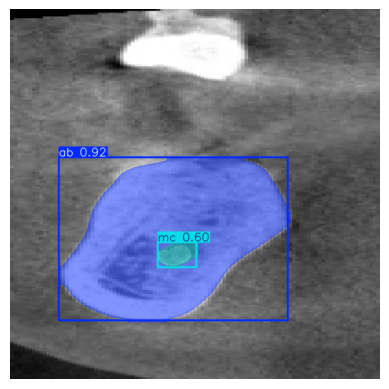

In [10]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from ultralytics import YOLO

model = YOLO("C:\\5025211148\\YOLOv9-Segmentation\\runs\\segment\\train22\\weights\\best.pt")  # load a custom model

# Predict with the model
results = model("C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1\\valid\\images\\slice_2_png.rf.773ebb3973e8d24b3610d7d5889312bf.jpg")


predicted_img = results[0].plot()
output_dir = "C:\\5025211148\\YOLOv9-Segmentation\\runs\\segment\\predict"
os.makedirs(output_dir, exist_ok=True)

output_image_path = os.path.join(output_dir, "predicted.jpg")

cv2.imwrite(output_image_path, predicted_img)

predicted_img_rgb = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2RGB)

plt.imshow(predicted_img_rgb)
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [11]:
model_path = r'C:\\5025211148\\YOLOv9-Segmentation\\runs\\segment\\train22\\weights\\best.pt'
valid_path = r'C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1\\valid\\images'
ground_truth_path = r'C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1\\valid\\labels'
gt_AB_path = r"C:\\5025211148\\YOLOv9-Segmentation\\\\Dataset Train Val\\gt-AB"
gt_MC_path = r"C:\\5025211148\\YOLOv9-Segmentation\\Dataset Train Val\\gt-MC"

segmented_AB_path = fr'C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB'
segmented_AB_path_2 = r'C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB'
segmented_AB_npy = r'C:\\5025211148\\YOLOv9-Segmentation\\yolov9c-segmented_AB.npy'

segmented_MC_path = fr'C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC'
segmented_MC_path_2 = r'C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC'
segmented_MC_npy = r'C:\\5025211148\\YOLOv9-Segmentation\\yolov9c-segmented_MC.npy'

for path in [gt_AB_path, gt_MC_path, segmented_AB_path, segmented_MC_path]:
  os.makedirs(path, exist_ok=True)

In [58]:
model_path = r'C:\\5025211148\\YOLOv9-Segmentation\\kfold_yolov9_seg\\fold3\\weights\\best.pt'
valid_path = r'C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\images'
ground_truth_path = r'C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\labels'
gt_AB_path = r"C:\\5025211148\\YOLOv9-Segmentation\\\\Dataset Train Val\\gt-AB"
gt_MC_path = r"C:\\5025211148\\YOLOv9-Segmentation\\Dataset Train Val\\gt-MC"

segmented_AB_path = fr'C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB'
segmented_AB_path_2 = r'C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB'
segmented_AB_npy = r'C:\\5025211148\\YOLOv9-Segmentation\\yolov9c-segmented_AB.npy'

segmented_MC_path = fr'C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC'
segmented_MC_path_2 = r'C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC'
segmented_MC_npy = r'C:\\5025211148\\YOLOv9-Segmentation\\yolov9c-segmented_MC.npy'

for path in [gt_AB_path, gt_MC_path, segmented_AB_path, segmented_MC_path]:
  os.makedirs(path, exist_ok=True)

In [59]:
import os
import re

# specify the directory path
directory_path = valid_path

# create an empty list to store the filenames with directory path
file_list = []

# iterate over the files in the directory
for filename in os.listdir(directory_path):
    # check if the item is a file
    if os.path.isfile(os.path.join(directory_path, filename)):
        # append the filename with directory path to the list
        file_list.append(os.path.join(directory_path, filename))

def extract_number(s):
    match = re.search(r'slice_(\d+)', s)  # Match 'slice_' followed by one or more digits
    return int(match.group(1)) if match else float('inf')

file_list = sorted(file_list, key=extract_number)
for filename in file_list:
    print(filename)
# print(file_list)  # Output: sorted file_list with filenames like 'slice_0', 'slice_1', 'slice_2', etc.


C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\images\slice_0_png.rf.b6a308ad17de783c210d9ceb410d76a1.jpg
C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\images\slice_1_png.rf.813ec633aebc1e939b902b040068a91a.jpg
C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\images\slice_2_png.rf.773ebb3973e8d24b3610d7d5889312bf.jpg
C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\images\slice_3_png.rf.2b7ac0dccdcc3241e2441dcdfe40b19a.jpg
C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\images\slice_4_png.rf.ed9951865dd8c8e9c4bb357b12d90bf3.jpg
C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\images\slice_5_png.rf.fa534a063f0865aba05bfb1f39bf17f1.jpg
C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\images\slice_6_png.rf.69513226c67a48924c9727490a40871b.jpg
C:\\5025211148\\YOLOv9-Segmentation\\merge-inez-1 copy\\valid\\images\slice_7_png.rf.911a9c8ba0e64b11ffd5e11ceb31250e.jpg
C:\\5025211148\\YOLOv9-S

In [60]:
from ultralytics import YOLO

# Load a model
model = YOLO(model_path, task='segment')  # load a pretrained model (recommended for training)

In [61]:
results = model(file_list, save=True)


0: 640x640 1 ab, 1 mc, 794.4ms
1: 640x640 1 ab, 1 mc, 794.4ms
2: 640x640 1 ab, 1 mc, 794.4ms
3: 640x640 1 ab, 1 mc, 794.4ms
4: 640x640 1 ab, 1 mc, 794.4ms
5: 640x640 1 ab, 1 mc, 794.4ms
6: 640x640 1 ab, 1 mc, 794.4ms
7: 640x640 1 ab, 1 mc, 794.4ms
8: 640x640 1 ab, 1 mc, 794.4ms
9: 640x640 1 ab, 1 mc, 794.4ms
10: 640x640 1 ab, 1 mc, 794.4ms
11: 640x640 1 ab, 1 mc, 794.4ms
12: 640x640 1 ab, 1 mc, 794.4ms
13: 640x640 1 ab, 1 mc, 794.4ms
14: 640x640 1 ab, 1 mc, 794.4ms
15: 640x640 1 ab, 1 mc, 794.4ms
16: 640x640 1 ab, 1 mc, 794.4ms
17: 640x640 1 ab, 794.4ms
18: 640x640 1 ab, 1 mc, 794.4ms
19: 640x640 1 ab, 1 mc, 794.4ms
20: 640x640 1 ab, 1 mc, 794.4ms
21: 640x640 1 ab, 1 mc, 794.4ms
22: 640x640 1 ab, 1 mc, 794.4ms
23: 640x640 1 ab, 1 mc, 794.4ms
24: 640x640 1 ab, 794.4ms
25: 640x640 1 ab, 1 mc, 794.4ms
26: 640x640 1 ab, 1 mc, 794.4ms
27: 640x640 1 ab, 1 mc, 794.4ms
28: 640x640 1 ab, 1 mc, 794.4ms
29: 640x640 1 ab, 1 mc, 794.4ms
30: 640x640 1 ab, 1 mc, 794.4ms
31: 640x640 1 ab, 1 mc, 794.4

In [62]:
print(len(results))

75


In [63]:
import torch
import cv2
import numpy as np
i = 0
x = 101
y = 200

for result in results:
  if(result.masks is not None):
    # get the AB masks
    boxes = result.boxes.data
    clss = boxes[:, 5]
    AB_indices = torch.where(clss == 0)
    AB_indices = (AB_indices[0][0].unsqueeze(0),)
    # AB_indices = AB_indices[0][0]
    print('class', clss)
    print('indices', AB_indices)
    # Convert mask to single channel image
    try:
      mask_raw = result.masks.cpu().data[[AB_indices]].numpy().transpose(1, 2, 0)
      # Convert single channel grayscale to 3 channel image
      mask_3channel = cv2.merge((mask_raw,mask_raw,mask_raw))

      # Get the size of the original image (height, width, channels)
      h2, w2, c2 = result.orig_img.shape

      # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
      mask = cv2.resize(mask_3channel, (w2, h2))

      # Convert BGR to HSV
      hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

      # Define range of brightness in HSV
      lower_black = np.array([0,0,0])
      upper_black = np.array([0,0,1])

      # Create a mask. Threshold the HSV image to get everything black
      mask = cv2.inRange(mask, lower_black, upper_black)

      # Invert the mask to get everything but black
      mask = cv2.bitwise_not(mask)

      # Apply the mask to the original image
      masked = cv2.bitwise_and(result.orig_img, result.orig_img, mask=mask)

      # Show the masked part of the image
      # cv2.imshow("mask", masked)
      resized_mask = cv2.resize(mask, (101, 200))
      cv2.imwrite(fr'{segmented_AB_path}\\merged_segs_{i}.jpg', resized_mask)
      print(fr'{segmented_AB_path}\\merged_segs_{i}.jpg')
    except Exception as e:
      print('error',e)
      # print('\n')
      continue
  else:
    width = 101
    height = 200
    black_image = np.zeros((height, width), dtype=np.uint8)
    print('ada yang kosong lo..')
    # Save the black image to a file
    cv2.imwrite(fr'{segmented_AB_path}\\merged_segs_{i}.jpg', black_image)
    print(fr'{segmented_AB_path}\\merged_segs_{i}.jpg')
  print('\n')
  i = i+1

class tensor([0., 1.], device='cuda:0')
indices (tensor([0], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\\merged_segs_0.jpg


class tensor([0., 1.], device='cuda:0')
indices (tensor([0], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\\merged_segs_1.jpg


class tensor([0., 1.], device='cuda:0')
indices (tensor([0], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\\merged_segs_2.jpg


class tensor([0., 1.], device='cuda:0')
indices (tensor([0], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\\merged_segs_3.jpg


class tensor([0., 1.], device='cuda:0')
indices (tensor([0], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\\merged_segs_4.jpg


class tensor([0., 1.], device='cuda:0')
indices (tensor([0], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\\merged_segs_5.jpg


class tensor([0., 1.], device='cuda:0')
indices (tensor([0], device='cuda:0'),)
C:\\5025211148

In [64]:
import os
import re

# specify the directory path
directory_path = segmented_AB_path_2

# create an empty list to store the filenames with directory path
file_list_AB = []

# iterate over the files in the directory
for filename in os.listdir(directory_path):
    # check if the item is a file
    if os.path.isfile(os.path.join(directory_path, filename)):
        # append the filename with directory path to the list
        file_list_AB.append(os.path.join(directory_path, filename))

def extract_number(s):
    match = re.search(r'merged_segs_(\d+)', s)  # Match 'merged_segs_' followed by one or more digits
    return int(match.group(1)) if match else float('inf')

file_list_AB = sorted(file_list_AB, key=extract_number)
for filename in file_list_AB:
    print(filename)
# print(file_list)  # Output: sorted file_list with filenames like 'merged_segs_0', 'merged_segs_1', 'merged_segs_2', etc.


C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_0.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_1.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_2.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_3.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_4.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_5.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_6.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_7.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_8.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_9.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_10.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_11.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_12.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_AB\merged_segs_13.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segment

In [65]:
import numpy as np
from PIL import Image  # If your images are in image files

# Assuming img_files is a list of file paths to the 2D images
# img_files = ['image1.png', 'image2.png', 'image3.png']  # Replace with your actual file paths

# Load the images and convert them to numpy arrays
image_arrays = [np.array(Image.open(img_file)) for img_file in file_list_AB]

# Stack the image arrays into a 3D numpy array
stacked_images = np.stack(image_arrays, axis=0)

# stacked_images is now a 3D numpy array where the first dimension represents the index of the image in the list

# Example usage:
print(stacked_images.shape)  # Output: (3, height, width, channels) assuming RGB images

np.save(segmented_AB_npy, stacked_images)

(75, 200, 101)


In [66]:
import torch
import cv2
i = 0
x = 101
y = 200

for result in results:
  if(result.masks is not None):
    # get the AB masks
    try:
      boxes = result.boxes.data
      clss = boxes[:, 5]
      AB_indices = torch.where(clss == 1)
      AB_indices = (AB_indices[0][0].unsqueeze(0),)
      # AB_indices = AB_indices[0][0]
      print('class', clss)
      print('indices', AB_indices)
      # Convert mask to single channel image
      mask_raw = result.masks.cpu().data[[AB_indices]].numpy().transpose(1, 2, 0)
      # Convert single channel grayscale to 3 channel image
      mask_3channel = cv2.merge((mask_raw,mask_raw,mask_raw))

      # Get the size of the original image (height, width, channels)
      h2, w2, c2 = result.orig_img.shape

      # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
      mask = cv2.resize(mask_3channel, (w2, h2))

      # Convert BGR to HSV
      hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

      # Define range of brightness in HSV
      lower_black = np.array([0,0,0])
      upper_black = np.array([0,0,1])

      # Create a mask. Threshold the HSV image to get everything black
      mask = cv2.inRange(mask, lower_black, upper_black)

      # Invert the mask to get everything but black
      mask = cv2.bitwise_not(mask)

      # Apply the mask to the original image
      masked = cv2.bitwise_and(result.orig_img, result.orig_img, mask=mask)

      # Show the masked part of the image
      # cv2.imshow("mask", masked)
      resized_mask = cv2.resize(mask, (101, 200))
      cv2.imwrite(fr'{segmented_MC_path}\\merged_segs_{i}.jpg', resized_mask)
      print(fr'{segmented_MC_path}\\merged_segs_{i}.jpg')
      print('ketemu')
    except Exception as e:
      print('error',e)
      width = 101
      height = 200
      black_image = np.zeros((height, width), dtype=np.uint8)
      print('tidak ada mc lo..')
      # Save the black image to a file
      cv2.imwrite(fr'{segmented_MC_path}\\merged_segs_{i}.jpg', black_image)
      print(fr'{segmented_MC_path}\\merged_segs_{i}.jpg')
      i = i+1
      continue
  else:
    width = 101
    height = 200
    black_image = np.zeros((height, width), dtype=np.uint8)
    print('ada yang kosong lo..')
    # Save the black image to a file
    cv2.imwrite(fr'{segmented_MC_path}\\merged_segs_{i}.jpg', black_image)
    print(fr'{segmented_MC_path}\\merged_segs_{i}.jpg')
  print('\n')
  i = i+1

class tensor([0., 1.], device='cuda:0')
indices (tensor([1], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\\merged_segs_0.jpg
ketemu


class tensor([0., 1.], device='cuda:0')
indices (tensor([1], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\\merged_segs_1.jpg
ketemu


class tensor([0., 1.], device='cuda:0')
indices (tensor([1], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\\merged_segs_2.jpg
ketemu


class tensor([0., 1.], device='cuda:0')
indices (tensor([1], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\\merged_segs_3.jpg
ketemu


class tensor([0., 1.], device='cuda:0')
indices (tensor([1], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\\merged_segs_4.jpg
ketemu


class tensor([0., 1.], device='cuda:0')
indices (tensor([1], device='cuda:0'),)
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\\merged_segs_5.jpg
ketemu


class tensor([0., 1.], device='cuda:0')
indices (ten

In [67]:
import os
import re

# specify the directory path
directory_path = segmented_MC_path_2

# create an empty list to store the filenames with directory path
file_list_MC = []

# iterate over the files in the directory
for filename in os.listdir(directory_path):
    # check if the item is a file
    if os.path.isfile(os.path.join(directory_path, filename)):
        # append the filename with directory path to the list
        file_list_MC.append(os.path.join(directory_path, filename))

def extract_number(s):
    match = re.search(r'merged_segs_(\d+)', s)  # Match 'merged_segs_' followed by one or more digits
    return int(match.group(1)) if match else float('inf')

file_list_MC = sorted(file_list_MC, key=extract_number)
for filename in file_list_MC:
    print(filename)
# print(file_list)  # Output: sorted file_list with filenames like 'merged_segs_0', 'merged_segs_1', 'merged_segs_2', etc.


C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_0.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_1.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_2.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_3.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_4.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_5.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_6.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_7.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_8.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_9.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_10.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_11.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_12.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segmented_MC\merged_segs_13.jpg
C:\\5025211148\\YOLOv9-Segmentation\\segment

In [68]:
import numpy as np
from PIL import Image  # If your images are in image files

# Assuming img_files is a list of file paths to the 2D images
# img_files = ['image1.png', 'image2.png', 'image3.png']  # Replace with your actual file paths

# Load the images and convert them to numpy arrays
image_arrays = [np.array(Image.open(img_file)) for img_file in file_list_MC]

# Stack the image arrays into a 3D numpy array
stacked_images = np.stack(image_arrays, axis=0)

# stacked_images is now a 3D numpy array where the first dimension represents the index of the image in the list

# Example usage:
print(stacked_images.shape)  # Output: (3, height, width, channels) assuming RGB images

np.save(segmented_MC_npy, stacked_images)

(75, 200, 101)


In [69]:
import os
import cv2
import numpy as np

# Directory paths
img_path = valid_path
gt_path = ground_truth_path
output_path = gt_AB_path

# Ensure output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Iterate over files in the image directory
for img_file in os.listdir(img_path):
    if img_file.endswith(".jpg") or img_file.endswith(".png"):  # adjust based on your image format
        # Read the image
        img = cv2.imread(os.path.join(img_path, img_file))

        # Create a blank white image with the same dimensions as the original image
        mask = np.ones_like(img) * 255

        # Read the corresponding ground truth file
        gt_file = os.path.splitext(img_file)[0] + ".txt"  # assuming ground truth files have the same name as images
        gt_file_path = os.path.join(gt_path, gt_file)

        if os.path.exists(gt_file_path):
            class_0_points = []
            class_1_points = []
            with open(gt_file_path, "r") as file:
                lines = file.readlines()
                for line in lines:
                    data = line.split()
                    class_label = int(data[0])
                    points = [(float(data[i]), float(data[i+1])) for i in range(1, len(data), 2)]
                    # Convert normalized coordinates to pixel coordinates
                    img_height, img_width, _ = img.shape
                    points = [(int(point[0] * img_width), int(point[1] * img_height)) for point in points]
                    if class_label == 0:
                        class_0_points.extend(points)
                    elif class_label == 1:
                        class_1_points.extend(points)

            # Create numpy arrays of points for drawing the polygons
            polygon_points_0 = np.array(class_0_points)
            polygon_points_1 = np.array(class_1_points)

            # Draw the filled polygons on the mask
            if len(polygon_points_0) > 0:
                cv2.fillPoly(mask, [polygon_points_0], color=(0, 0, 0))
            if len(polygon_points_1) > 0:
                cv2.fillPoly(mask, [polygon_points_1], color=(255, 255, 255))

            # Resize the output image to 101x200
            mask = 255 - mask
            mask_resized = cv2.resize(mask, (101, 200))

            # Save the output image as JPEG
            output_file = os.path.splitext(img_file)[0] + "_output.jpg"
            output_file_path = os.path.join(output_path, output_file)
            cv2.imwrite(output_file_path, mask_resized)

            print(f"Saved resized output image for {img_file} as {output_file_path}")
        else:
            print(f"No ground truth file found for {img_file}")

# image_loader = ImageLoader(output_path)
# gt_AB = image_loader.load_images()


Saved resized output image for slice_0_png.rf.b6a308ad17de783c210d9ceb410d76a1.jpg as C:\\5025211148\\YOLOv9-Segmentation\\\\Dataset Train Val\\gt-AB\slice_0_png.rf.b6a308ad17de783c210d9ceb410d76a1_output.jpg
Saved resized output image for slice_10_png.rf.8cfc23276c5e0a0a9c082a84937bbfa9.jpg as C:\\5025211148\\YOLOv9-Segmentation\\\\Dataset Train Val\\gt-AB\slice_10_png.rf.8cfc23276c5e0a0a9c082a84937bbfa9_output.jpg
Saved resized output image for slice_11_png.rf.2f4ba45901be13bdd4a6d27191f04632.jpg as C:\\5025211148\\YOLOv9-Segmentation\\\\Dataset Train Val\\gt-AB\slice_11_png.rf.2f4ba45901be13bdd4a6d27191f04632_output.jpg
Saved resized output image for slice_12_png.rf.e697ea8e2a874fe7e9b6625b141d770f.jpg as C:\\5025211148\\YOLOv9-Segmentation\\\\Dataset Train Val\\gt-AB\slice_12_png.rf.e697ea8e2a874fe7e9b6625b141d770f_output.jpg
Saved resized output image for slice_13_png.rf.3e77ef333ad7540a2e71c11b85729e94.jpg as C:\\5025211148\\YOLOv9-Segmentation\\\\Dataset Train Val\\gt-AB\slice_1

In [70]:
import os
import cv2
import numpy as np

# Directory paths
img_path = valid_path
gt_path = ground_truth_path
output_path = gt_MC_path

# Ensure output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Iterate over files in the image directory
for img_file in os.listdir(img_path):
    if img_file.endswith(".jpg") or img_file.endswith(".png"):  # adjust based on your image format
        # Read the image
        img = cv2.imread(os.path.join(img_path, img_file))

        # Create a blank white image with the same dimensions as the original image
        mask = np.ones_like(img) * 255

        # Read the corresponding ground truth file
        gt_file = os.path.splitext(img_file)[0] + ".txt"  # assuming ground truth files have the same name as images
        gt_file_path = os.path.join(gt_path, gt_file)

        if os.path.exists(gt_file_path):
            class_0_points = []
            with open(gt_file_path, "r") as file:
                lines = file.readlines()
                for line in lines:
                    data = line.split()
                    class_label = int(data[0])
                    if class_label == 1:
                        points = [(float(data[i]), float(data[i+1])) for i in range(1, len(data), 2)]
                        # Convert normalized coordinates to pixel coordinates
                        img_height, img_width, _ = img.shape
                        points = [(int(point[0] * img_width), int(point[1] * img_height)) for point in points]
                        class_0_points.extend(points)

            # Create a numpy array of points for drawing the polygon
            polygon_points = np.array(class_0_points)

            # Draw the filled polygon on the mask
            if len(polygon_points) > 0:
                cv2.fillPoly(mask, [polygon_points], color=(0, 0, 0))

            # Resize the output image to 101x200
            mask = 255 - mask
            mask_resized = cv2.resize(mask, (101, 200))

            # Save the output image as JPEG
            output_file = os.path.splitext(img_file)[0] + "_output.jpg"
            output_file_path = os.path.join(output_path, output_file)
            cv2.imwrite(output_file_path, mask_resized)

            print(f"Saved resized output image for {img_file} as {output_file_path}")
        else:
            print(f"No ground truth file found for {img_file}")

# image_loader = ImageLoader(output_path)
# gt_MC = image_loader.load_images()

Saved resized output image for slice_0_png.rf.b6a308ad17de783c210d9ceb410d76a1.jpg as C:\\5025211148\\YOLOv9-Segmentation\\Dataset Train Val\\gt-MC\slice_0_png.rf.b6a308ad17de783c210d9ceb410d76a1_output.jpg
Saved resized output image for slice_10_png.rf.8cfc23276c5e0a0a9c082a84937bbfa9.jpg as C:\\5025211148\\YOLOv9-Segmentation\\Dataset Train Val\\gt-MC\slice_10_png.rf.8cfc23276c5e0a0a9c082a84937bbfa9_output.jpg
Saved resized output image for slice_11_png.rf.2f4ba45901be13bdd4a6d27191f04632.jpg as C:\\5025211148\\YOLOv9-Segmentation\\Dataset Train Val\\gt-MC\slice_11_png.rf.2f4ba45901be13bdd4a6d27191f04632_output.jpg
Saved resized output image for slice_12_png.rf.e697ea8e2a874fe7e9b6625b141d770f.jpg as C:\\5025211148\\YOLOv9-Segmentation\\Dataset Train Val\\gt-MC\slice_12_png.rf.e697ea8e2a874fe7e9b6625b141d770f_output.jpg
Saved resized output image for slice_13_png.rf.3e77ef333ad7540a2e71c11b85729e94.jpg as C:\\5025211148\\YOLOv9-Segmentation\\Dataset Train Val\\gt-MC\slice_13_png.rf.3

In [71]:
import os
import cv2
import numpy as np
import re

def read_images_as_binary_sorted(path, threshold=127):
    image_list = []

    # Get all files in the folder
    files = os.listdir(path)

    # Sort files based on filenames
    sorted_files = sorted(files, key=sort_key)

    # Iterate over sorted files
    for file_name in sorted_files:
        # Check if the file is an image (you can adjust the condition based on your image formats)
        if file_name.endswith(".jpg") or file_name.endswith(".png"):
            # Read the image in grayscale
            image_path = os.path.join(path, file_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                # Apply thresholding to convert grayscale to binary image
                _, binary_image = cv2.threshold(image, threshold, 1, cv2.THRESH_BINARY)
                image_list.append(binary_image)
                # unique_values, counts = np.unique(binary_image, return_counts=True)
                # for value, count in zip(unique_values, counts):
                    # print(f"{value}: {count}")

    # Convert the list of images to a numpy array
    image_array = np.array(image_list)
    return image_array

def sort_key(file_name):
    parts = re.split(r'(\d+)', file_name)
    parts[1::2] = map(int, parts[1::2])  # Convert numeric parts to integers
    return parts

# Example usage:
# sorted_images = read_images_as_grayscale_sorted("/path/to/images")


In [72]:
# Example usage:
path_to_images = gt_AB_path
gt_AB = read_images_as_binary_sorted(path_to_images)
print("Shape of images array:", gt_AB.shape)

Shape of images array: (75, 200, 101)


In [73]:

# Example usage:
path_to_images = gt_MC_path
gt_MC = read_images_as_binary_sorted(path_to_images)
print("Shape of images array:", gt_MC.shape)

Shape of images array: (75, 200, 101)


In [74]:

# Example usage:
path_to_images = segmented_AB_path
segmented_AB = read_images_as_binary_sorted(path_to_images)
print("Shape of images array:", segmented_AB.shape)

Shape of images array: (75, 200, 101)


In [75]:

# Example usage:
path_to_images = segmented_MC_path
segmented_MC = read_images_as_binary_sorted(path_to_images)
print("Shape of images array:", segmented_MC.shape)

Shape of images array: (75, 200, 101)


In [76]:
import numpy as np
from sklearn.metrics import confusion_matrix


def calculate_iou(gt, pred):
    unique_gt = np.unique(gt)
    unique_pred = np.unique(pred)

    # If both gt and pred contain only one unique value and they are equal,
    # then IoU is 1
    if len(unique_gt) == len(unique_pred) == 1 and unique_gt[0] == unique_pred[0]:
        return 1.0

    # print(gt.shape)
    cm = confusion_matrix(gt.flatten(), pred.flatten())
    # unique_values, counts = np.unique(gt, return_counts=True)
    # for value, count in zip(unique_values, counts):
    #    print(f"{value}: {count}")
    # print(cm)
    intersection = np.diag(cm) #TN dan TP
    union = np.sum(cm, axis=0) + np.sum(cm, axis=1) - intersection
    # print(np.sum(cm, axis=0))
    # print(np.sum(cm, axis=1))
    # print(intersection)
    # iou = np.mean((intersection + 1e-10) / (union + 1e-10))
    # only calculate the iou for AB or MC thats why we use index [1] in intersection
    iou = (intersection[1] + 1e-10) / (union[1] + 1e-10)
    return iou

def calculate_dice_score(gt, pred):
    unique_gt = np.unique(gt)
    unique_pred = np.unique(pred)

    # If both gt and pred contain only one unique value and they are equal,
    # then IoU is 1
    if len(unique_gt) == len(unique_pred) == 1 and unique_gt[0] == unique_pred[0]:
        return 1.0
    cm = confusion_matrix(gt.flatten(), pred.flatten())
    intersection = np.diag(cm)
    union_dice = np.sum(cm, axis=0) + np.sum(cm, axis=1)
    # dice_score = np.mean(2 * (intersection + 1e-10) / (union_dice + 1e-10))
    dice_score = 2 * (intersection[1] + 1e-10) / (union_dice[1] + 1e-10)
    return dice_score

def calculate_average_iou_and_dice(gt_images, pred_images):
    num_images = gt_images.shape[0]
    iou_scores = []
    dice_scores = []

    for i in range(num_images):
        gt_image = gt_images[i]
        pred_image = pred_images[i]
        iou = calculate_iou(gt_image, pred_image)
        dice = calculate_dice_score(gt_image, pred_image)
        print(i,"iou:",iou)
        print(i,"dice:",dice)
        iou_scores.append(iou)
        dice_scores.append(dice)

    avg_iou = np.nanmean(iou_scores)  # Use np.nanmean to handle NaN values
    avg_dice = np.nanmean(dice_scores)  # Use np.nanmean to handle NaN values
    return avg_iou, avg_dice

# Example usage:
# gt_images and pred_images are numpy arrays containing grayscale images
# Each array should have shape (num_images, height, width)


In [77]:
avg_iou, avg_dice = calculate_average_iou_and_dice(segmented_AB, gt_AB)
print("Average IOU:", avg_iou)
print("Average DSC:", avg_dice)
print()
# print("Average Dice Score:", avg_dice)

0 iou: 0.9420251836306416
0 dice: 0.9701472376063897
1 iou: 0.9416038751345549
1 dice: 0.9699237699237843
2 iou: 0.9256933542647848
2 dice: 0.9614130434782749
3 iou: 0.9419525065963076
3 dice: 0.9701086956521879
4 iou: 0.9491214266981393
4 dice: 0.9738966630785929
5 iou: 0.9487045276105744
5 dice: 0.9736771420897263
6 iou: 0.9477477477477491
6 dice: 0.9731729879741117
7 iou: 0.9488710096029082
7 dice: 0.9737648155546814
8 iou: 0.9569976544175148
8 dice: 0.9780263683579841
9 iou: 0.9419470845106617
9 dice: 0.9701058201058337
10 iou: 0.9428274428274444
10 dice: 0.9705724986624
11 iou: 0.9451011294982941
11 dice: 0.9717758271438356
12 iou: 0.9364131845315355
12 dice: 0.9671625787428098
13 iou: 0.929788332472898
13 dice: 0.963616907437146
14 iou: 0.948979591836736
14 dice: 0.9738219895288093
15 iou: 0.9399391789153588
15 dice: 0.969039843239726
16 iou: 0.9447776111944042
16 dice: 0.9716047796479639
17 iou: 0.8814204185161737
17 dice: 0.9369733737782451
18 iou: 0.89908854166667
18 dice: 0.9

In [78]:
avg_iou, avg_dice = calculate_average_iou_and_dice(segmented_MC, gt_MC)
print("Average IOU:", avg_iou)
print("Average DSC:", avg_dice)
# print("Average Dice Score:", avg_dice)

0 iou: 0.683098591549519
0 dice: 0.8117154811720454
1 iou: 0.8164556962026478
1 dice: 0.8989547038331362
2 iou: 0.7924528301888099
2 dice: 0.884210526316181
3 iou: 0.7638888888890529
3 dice: 0.866141732283911
4 iou: 0.6971830985917626
4 dice: 0.8215767634859662
5 iou: 0.6965517241381404
5 dice: 0.8211382113825931
6 iou: 0.7372262773724546
6 dice: 0.8487394957988031
7 iou: 0.8166666666668194
7 dice: 0.8990825688078445
8 iou: 0.918699186991936
8 dice: 0.9576271186445096
9 iou: 0.8151260504203234
9 dice: 0.8981481481486583
10 iou: 0.7514450867053459
10 dice: 0.858085808581235
11 iou: 0.6686746987953803
11 dice: 0.8014440433217324
12 iou: 0.740259740259909
12 dice: 0.8507462686571453
13 iou: 0.5828571428573813
13 dice: 0.7364620938632721
14 iou: 0.6250000000002345
14 dice: 0.7692307692312427
15 iou: 0.7639751552796498
15 dice: 0.8661971830989909
16 iou: 0.6111111111113512
16 dice: 0.7586206896556481
17 iou: 4.2918454935603903e-13
17 dice: 8.583690987120781e-13
18 iou: 0.28231292517031215
1